In [1]:
import os
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
from tqdm import tqdm

plt.rcParams["image.cmap"] = "jet"

In [2]:
# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs/")
# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

/net/micdata/data2/12IDC/ptychosaxs/trained_model


In [3]:
# Load preprocessed data
num=32#17
numDPs=10800#10000

# Load the data once instead of three times
data_path = os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_numDPs{numDPs}.npz'))
data = np.load(data_path)

# Extract the arrays
amp_conv_red = data['amp_conv_red']
amp_ideal_red = data['amp_ideal_red']
amp_probe_red = data['amp_probe_red']

In [4]:
# Set the number of patterns in test, train or validation set
NTEST = amp_conv_red.shape[0]//4
NTRAIN = amp_conv_red.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

8100 2700 1350


In [5]:
EPOCHS = 500
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

no_probe=True
H,W=amp_ideal_red[0].shape[0],amp_ideal_red[0].shape[1]
print(H,W)

GPUs: 2 Batch size: 32 Learning rate: 0.002
256 256


In [6]:
#separate data and convert to tensors and shuffle
no_probe=True

tst_start = amp_conv_red.shape[0]-NTEST

X_train = amp_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = amp_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Xp_train = amp_probe_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Xp_test = amp_probe_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Y_I_train = amp_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

X_train, Xp_train, Y_I_train = shuffle(X_train, Xp_train, Y_I_train, random_state=0)

#Training data
X_train_tensor = torch.Tensor(X_train)
Xp_train_tensor = torch.Tensor(Xp_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Xp_test_tensor = torch.Tensor(Xp_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape,Xp_train_tensor.shape, Y_I_train_tensor.shape)


if no_probe:
    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)
else:
    train_data = TensorDataset(X_train_tensor,Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)


N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))


#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256])
6750 2 1350 2700


In [7]:
import sys
import os
import importlib

# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/')))

# First, try to import the module
try:
    import encoder1_no_Unet
    # Force reload the module
    importlib.reload(encoder1_no_Unet)
    # Now import the class from the freshly reloaded module
    from encoder1_no_Unet import recon_model
    print("Successfully imported recon_model")
    unet_status = "no_Unet"
    loss_function = "L2"
except Exception as e:
    print(f"Import error: {e}")
    
# First, try to import the module
# try:
#     import encoder1
#     importlib.reload(encoder1)
#     # Now import the class from the freshly reloaded module
#     from encoder1 import recon_model
#     print("Successfully imported recon_model")
#     unet_status = "Unet"
#     #loss_function = "pearson_loss"
#     loss_function = "L2"
# except Exception as e:
#     print(f"Import error: {e}")


model = recon_model()
load_prev_model=False

Successfully imported recon_model


In [8]:
if no_probe:
    for ampsI,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI)#,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break
else:
    for ampsI,ampsP,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model)

model = model.to(device)
print(model)

batch size: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32
Let's use 2 GPUs!
DataParallel(
  (module): recon_model(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder3): Sequential(
      (0): Co

In [9]:
def pearson_loss(output, target):
    """
    Compute 1 - Pearson correlation coefficient as a loss function.
    Args:
        output: Predicted values (B, C, H, W)
        target: Target values (B, C, H, W)
    Returns:
        loss: 1 - correlation (to minimize)
    """
    # Flatten the spatial dimensions
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    
    # Mean of each image
    output_mean = output_flat.mean(dim=1, keepdim=True)
    target_mean = target_flat.mean(dim=1, keepdim=True)
    
    # Centered variables
    output_centered = output_flat - output_mean
    target_centered = target_flat - target_mean
    
    # Correlation
    numerator = (output_centered * target_centered).sum(dim=1)
    denominator = torch.sqrt((output_centered**2).sum(dim=1) * (target_centered**2).sum(dim=1))
    
    # Avoid division by zero
    correlation = numerator / (denominator + 1e-8)
    
    # Average over batch and convert to loss (1 - correlation)
    loss = 1 - correlation.mean()
    
    #Negaive pearson loss
    #loss = 1 + correlation.mean()
    
    return loss

In [10]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 (6) number of iterations, step_size is half cycle
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))



#criterion = nn.L1Loss()
criterion = nn.MSELoss()
    

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
                                            
#Function to update saved model if validation loss is minimum

def update_saved_model(model, path, current_epoch, best_val_loss):
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Save the best overall model
    if (NGPUS>1):    
        torch.save(model.module.state_dict(), path / f'best_model_ZCB_9_{num}_{unet_status}_{loss_function}.pth')
    else:
        torch.save(model, path / f'best_model_ZCB_9_{num}_{unet_status}_{loss_function}.pth')
    
    # Define epoch intervals (50, 100, 150, etc.)
    epoch_intervals = [2, 10, 25, 50, 100, 150, 200, 250, 300, 400, 500]
    
    # For each interval, save the best model within that interval
    for interval in epoch_intervals:
        if current_epoch <= interval:
            # Create a filename that includes the epoch interval
            interval_filename = f'best_model_ZCB_9_{num}_{unet_status}_epoch_{interval}_{loss_function}.pth'
            interval_path = path / interval_filename
            
            # If this is the first time we're saving for this interval, save the model
            if not interval_path.exists():
                if (NGPUS>1):
                    torch.save(model.module.state_dict(), interval_path)
                else:
                    torch.save(model, interval_path)
                print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")
            # If we already have a model for this interval, only update if the current loss is better
            else:
                # Load the previous best loss for this interval
                prev_loss_path = path / f'best_loss_epoch_{num}_{unet_status}_{interval}_{loss_function}.txt'
                if prev_loss_path.exists():
                    with open(prev_loss_path, 'r') as f:
                        prev_best_loss = float(f.read().strip())
                    
                    # Update if current loss is better
                    if best_val_loss < prev_best_loss:
                        if (NGPUS>1):
                            torch.save(model.module.state_dict(), interval_path)
                        else:
                            torch.save(model, interval_path)
                        with open(prev_loss_path, 'w') as f:
                            f.write(str(best_val_loss))
                        print(f"Updating best model for epoch interval {interval} at epoch {current_epoch}")
                else:
                    # First time saving for this interval
                    if (NGPUS>1):
                        torch.save(model.module.state_dict(), interval_path)
                    else:
                        torch.save(model, interval_path)
                    with open(prev_loss_path, 'w') as f:
                        f.write(str(best_val_loss))
                    print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")



def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        #loss_a = pearson_loss(pred_amps,amps)
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 
    
def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        val_loss_a = criterion(pred_amps,amps)
        #val_loss_a = pearson_loss(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
  
    #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH, metrics['current_epoch'], tot_val_loss/j)



211.0
LR step size is: 1266.0 which is every 6 epochs


In [11]:
# Initialize metrics dictionary with current_epoch
metrics = {
    'losses': [],
    'val_losses': [],
    'lrs': [],
    'best_val_loss': float('inf'),
    'current_epoch': 0
}

for epoch in range (EPOCHS):
    metrics['current_epoch'] = epoch  # Update current epoch in metrics
    
    #Set model to train mode
    model.train() 
    #Training loop
    train(trainloader,metrics)
    
    #Switch model to eval mode
    model.eval()
    
    #Validation loop
    validate(validloader,metrics)
    print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
    print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
    print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

211it [00:43,  4.82it/s]


Saving improved model after Val Loss improved from inf to 0.01316
Saving best model for epoch interval 2 at epoch 0
Saving best model for epoch interval 10 at epoch 0
Saving best model for epoch interval 25 at epoch 0
Saving best model for epoch interval 50 at epoch 0
Saving best model for epoch interval 100 at epoch 0
Saving best model for epoch interval 150 at epoch 0
Saving best model for epoch interval 200 at epoch 0
Saving best model for epoch interval 250 at epoch 0
Saving best model for epoch interval 300 at epoch 0
Saving best model for epoch interval 400 at epoch 0
Saving best model for epoch interval 500 at epoch 0
Epoch: 0 | Total  | Train Loss: 0.00430 | Val Loss: 0.01316
Epoch: 0 | Amp | Train Loss: 0.00430 | Val Loss: 0.01316
Epoch: 0 | Ending LR: 0.000500 


211it [00:18, 11.16it/s]


Epoch: 1 | Total  | Train Loss: 0.00126 | Val Loss: 0.01571
Epoch: 1 | Amp | Train Loss: 0.00126 | Val Loss: 0.01571
Epoch: 1 | Ending LR: 0.000800 


211it [00:18, 11.19it/s]


Saving improved model after Val Loss improved from 0.01316 to 0.00944
Saving best model for epoch interval 2 at epoch 2
Saving best model for epoch interval 10 at epoch 2
Saving best model for epoch interval 25 at epoch 2
Saving best model for epoch interval 50 at epoch 2
Saving best model for epoch interval 100 at epoch 2
Saving best model for epoch interval 150 at epoch 2
Saving best model for epoch interval 200 at epoch 2
Saving best model for epoch interval 250 at epoch 2
Saving best model for epoch interval 300 at epoch 2
Saving best model for epoch interval 400 at epoch 2
Saving best model for epoch interval 500 at epoch 2
Epoch: 2 | Total  | Train Loss: 0.00122 | Val Loss: 0.00944
Epoch: 2 | Amp | Train Loss: 0.00122 | Val Loss: 0.00944
Epoch: 2 | Ending LR: 0.001100 


211it [00:18, 11.20it/s]


Saving improved model after Val Loss improved from 0.00944 to 0.00186
Updating best model for epoch interval 10 at epoch 3
Updating best model for epoch interval 25 at epoch 3
Updating best model for epoch interval 50 at epoch 3
Updating best model for epoch interval 100 at epoch 3
Updating best model for epoch interval 150 at epoch 3
Updating best model for epoch interval 200 at epoch 3
Updating best model for epoch interval 250 at epoch 3
Updating best model for epoch interval 300 at epoch 3
Updating best model for epoch interval 400 at epoch 3
Updating best model for epoch interval 500 at epoch 3
Epoch: 3 | Total  | Train Loss: 0.00113 | Val Loss: 0.00186
Epoch: 3 | Amp | Train Loss: 0.00113 | Val Loss: 0.00186
Epoch: 3 | Ending LR: 0.001400 


211it [00:18, 11.17it/s]


Epoch: 4 | Total  | Train Loss: 0.00341 | Val Loss: 0.02298
Epoch: 4 | Amp | Train Loss: 0.00341 | Val Loss: 0.02298
Epoch: 4 | Ending LR: 0.001700 


211it [00:19, 11.09it/s]


Epoch: 5 | Total  | Train Loss: 0.00155 | Val Loss: 0.01259
Epoch: 5 | Amp | Train Loss: 0.00155 | Val Loss: 0.01259
Epoch: 5 | Ending LR: 0.002000 


211it [00:18, 11.14it/s]


Epoch: 6 | Total  | Train Loss: 0.00151 | Val Loss: 0.00590
Epoch: 6 | Amp | Train Loss: 0.00151 | Val Loss: 0.00590
Epoch: 6 | Ending LR: 0.001700 


211it [00:18, 11.12it/s]


Epoch: 7 | Total  | Train Loss: 0.00136 | Val Loss: 0.00330
Epoch: 7 | Amp | Train Loss: 0.00136 | Val Loss: 0.00330
Epoch: 7 | Ending LR: 0.001400 


211it [00:18, 11.12it/s]


Epoch: 8 | Total  | Train Loss: 0.00127 | Val Loss: 0.00195
Epoch: 8 | Amp | Train Loss: 0.00127 | Val Loss: 0.00195
Epoch: 8 | Ending LR: 0.001100 


211it [00:19, 10.95it/s]


Epoch: 9 | Total  | Train Loss: 0.00120 | Val Loss: 0.00211
Epoch: 9 | Amp | Train Loss: 0.00120 | Val Loss: 0.00211
Epoch: 9 | Ending LR: 0.000800 


211it [00:19, 11.08it/s]


Saving improved model after Val Loss improved from 0.00186 to 0.00163
Updating best model for epoch interval 10 at epoch 10
Updating best model for epoch interval 25 at epoch 10
Updating best model for epoch interval 50 at epoch 10
Updating best model for epoch interval 100 at epoch 10
Updating best model for epoch interval 150 at epoch 10
Updating best model for epoch interval 200 at epoch 10
Updating best model for epoch interval 250 at epoch 10
Updating best model for epoch interval 300 at epoch 10
Updating best model for epoch interval 400 at epoch 10
Updating best model for epoch interval 500 at epoch 10
Epoch: 10 | Total  | Train Loss: 0.00108 | Val Loss: 0.00163
Epoch: 10 | Amp | Train Loss: 0.00108 | Val Loss: 0.00163
Epoch: 10 | Ending LR: 0.000500 


211it [00:19, 11.09it/s]


Saving improved model after Val Loss improved from 0.00163 to 0.00099
Updating best model for epoch interval 25 at epoch 11
Updating best model for epoch interval 50 at epoch 11
Updating best model for epoch interval 100 at epoch 11
Updating best model for epoch interval 150 at epoch 11
Updating best model for epoch interval 200 at epoch 11
Updating best model for epoch interval 250 at epoch 11
Updating best model for epoch interval 300 at epoch 11
Updating best model for epoch interval 400 at epoch 11
Updating best model for epoch interval 500 at epoch 11
Epoch: 11 | Total  | Train Loss: 0.00100 | Val Loss: 0.00099
Epoch: 11 | Amp | Train Loss: 0.00100 | Val Loss: 0.00099
Epoch: 11 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 12 | Total  | Train Loss: 0.00096 | Val Loss: 0.00116
Epoch: 12 | Amp | Train Loss: 0.00096 | Val Loss: 0.00116
Epoch: 12 | Ending LR: 0.000350 


211it [00:19, 11.06it/s]


Epoch: 13 | Total  | Train Loss: 0.00098 | Val Loss: 0.00105
Epoch: 13 | Amp | Train Loss: 0.00098 | Val Loss: 0.00105
Epoch: 13 | Ending LR: 0.000500 


211it [00:18, 11.12it/s]


Epoch: 14 | Total  | Train Loss: 0.00098 | Val Loss: 0.00233
Epoch: 14 | Amp | Train Loss: 0.00098 | Val Loss: 0.00233
Epoch: 14 | Ending LR: 0.000650 


211it [00:18, 11.12it/s]


Epoch: 15 | Total  | Train Loss: 0.00098 | Val Loss: 0.00104
Epoch: 15 | Amp | Train Loss: 0.00098 | Val Loss: 0.00104
Epoch: 15 | Ending LR: 0.000800 


211it [00:18, 11.13it/s]


Epoch: 16 | Total  | Train Loss: 0.00098 | Val Loss: 0.00108
Epoch: 16 | Amp | Train Loss: 0.00098 | Val Loss: 0.00108
Epoch: 16 | Ending LR: 0.000950 


211it [00:19, 11.04it/s]


Epoch: 17 | Total  | Train Loss: 0.00098 | Val Loss: 0.00111
Epoch: 17 | Amp | Train Loss: 0.00098 | Val Loss: 0.00111
Epoch: 17 | Ending LR: 0.001100 


211it [00:18, 11.15it/s]


Epoch: 18 | Total  | Train Loss: 0.00096 | Val Loss: 0.00119
Epoch: 18 | Amp | Train Loss: 0.00096 | Val Loss: 0.00119
Epoch: 18 | Ending LR: 0.000950 


211it [00:18, 11.12it/s]


Epoch: 19 | Total  | Train Loss: 0.00095 | Val Loss: 0.00289
Epoch: 19 | Amp | Train Loss: 0.00095 | Val Loss: 0.00289
Epoch: 19 | Ending LR: 0.000800 


211it [00:18, 11.14it/s]


Epoch: 20 | Total  | Train Loss: 0.00093 | Val Loss: 0.00108
Epoch: 20 | Amp | Train Loss: 0.00093 | Val Loss: 0.00108
Epoch: 20 | Ending LR: 0.000650 


211it [00:19, 11.07it/s]


Saving improved model after Val Loss improved from 0.00099 to 0.00094
Updating best model for epoch interval 25 at epoch 21
Updating best model for epoch interval 50 at epoch 21
Updating best model for epoch interval 100 at epoch 21
Updating best model for epoch interval 150 at epoch 21
Updating best model for epoch interval 200 at epoch 21
Updating best model for epoch interval 250 at epoch 21
Updating best model for epoch interval 300 at epoch 21
Updating best model for epoch interval 400 at epoch 21
Updating best model for epoch interval 500 at epoch 21
Epoch: 21 | Total  | Train Loss: 0.00088 | Val Loss: 0.00094
Epoch: 21 | Amp | Train Loss: 0.00088 | Val Loss: 0.00094
Epoch: 21 | Ending LR: 0.000500 


211it [00:18, 11.15it/s]


Saving improved model after Val Loss improved from 0.00094 to 0.00090
Updating best model for epoch interval 25 at epoch 22
Updating best model for epoch interval 50 at epoch 22
Updating best model for epoch interval 100 at epoch 22
Updating best model for epoch interval 150 at epoch 22
Updating best model for epoch interval 200 at epoch 22
Updating best model for epoch interval 250 at epoch 22
Updating best model for epoch interval 300 at epoch 22
Updating best model for epoch interval 400 at epoch 22
Updating best model for epoch interval 500 at epoch 22
Epoch: 22 | Total  | Train Loss: 0.00084 | Val Loss: 0.00090
Epoch: 22 | Amp | Train Loss: 0.00084 | Val Loss: 0.00090
Epoch: 22 | Ending LR: 0.000350 


211it [00:18, 11.13it/s]


Epoch: 23 | Total  | Train Loss: 0.00080 | Val Loss: 0.00091
Epoch: 23 | Amp | Train Loss: 0.00080 | Val Loss: 0.00091
Epoch: 23 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Saving improved model after Val Loss improved from 0.00090 to 0.00081
Updating best model for epoch interval 25 at epoch 24
Updating best model for epoch interval 50 at epoch 24
Updating best model for epoch interval 100 at epoch 24
Updating best model for epoch interval 150 at epoch 24
Updating best model for epoch interval 200 at epoch 24
Updating best model for epoch interval 250 at epoch 24
Updating best model for epoch interval 300 at epoch 24
Updating best model for epoch interval 400 at epoch 24
Updating best model for epoch interval 500 at epoch 24
Epoch: 24 | Total  | Train Loss: 0.00078 | Val Loss: 0.00081
Epoch: 24 | Amp | Train Loss: 0.00078 | Val Loss: 0.00081
Epoch: 24 | Ending LR: 0.000275 


211it [00:19, 11.10it/s]


Epoch: 25 | Total  | Train Loss: 0.00079 | Val Loss: 0.00098
Epoch: 25 | Amp | Train Loss: 0.00079 | Val Loss: 0.00098
Epoch: 25 | Ending LR: 0.000350 


211it [00:18, 11.12it/s]


Epoch: 26 | Total  | Train Loss: 0.00080 | Val Loss: 0.00141
Epoch: 26 | Amp | Train Loss: 0.00080 | Val Loss: 0.00141
Epoch: 26 | Ending LR: 0.000425 


211it [00:19, 10.99it/s]


Epoch: 27 | Total  | Train Loss: 0.00081 | Val Loss: 0.00110
Epoch: 27 | Amp | Train Loss: 0.00081 | Val Loss: 0.00110
Epoch: 27 | Ending LR: 0.000500 


211it [00:19, 11.08it/s]


Epoch: 28 | Total  | Train Loss: 0.00083 | Val Loss: 0.00102
Epoch: 28 | Amp | Train Loss: 0.00083 | Val Loss: 0.00102
Epoch: 28 | Ending LR: 0.000575 


211it [00:19, 11.10it/s]


Epoch: 29 | Total  | Train Loss: 0.00081 | Val Loss: 0.00087
Epoch: 29 | Amp | Train Loss: 0.00081 | Val Loss: 0.00087
Epoch: 29 | Ending LR: 0.000650 


211it [00:18, 11.16it/s]


Epoch: 30 | Total  | Train Loss: 0.00081 | Val Loss: 0.00100
Epoch: 30 | Amp | Train Loss: 0.00081 | Val Loss: 0.00100
Epoch: 30 | Ending LR: 0.000575 


211it [00:19, 11.10it/s]


Epoch: 31 | Total  | Train Loss: 0.00078 | Val Loss: 0.00087
Epoch: 31 | Amp | Train Loss: 0.00078 | Val Loss: 0.00087
Epoch: 31 | Ending LR: 0.000500 


211it [00:18, 11.15it/s]


Epoch: 32 | Total  | Train Loss: 0.00077 | Val Loss: 0.00089
Epoch: 32 | Amp | Train Loss: 0.00077 | Val Loss: 0.00089
Epoch: 32 | Ending LR: 0.000425 


211it [00:19, 11.10it/s]


Saving improved model after Val Loss improved from 0.00081 to 0.00081
Updating best model for epoch interval 50 at epoch 33
Updating best model for epoch interval 100 at epoch 33
Updating best model for epoch interval 150 at epoch 33
Updating best model for epoch interval 200 at epoch 33
Updating best model for epoch interval 250 at epoch 33
Updating best model for epoch interval 300 at epoch 33
Updating best model for epoch interval 400 at epoch 33
Updating best model for epoch interval 500 at epoch 33
Epoch: 33 | Total  | Train Loss: 0.00075 | Val Loss: 0.00081
Epoch: 33 | Amp | Train Loss: 0.00075 | Val Loss: 0.00081
Epoch: 33 | Ending LR: 0.000350 


211it [00:18, 11.19it/s]


Saving improved model after Val Loss improved from 0.00081 to 0.00077
Updating best model for epoch interval 50 at epoch 34
Updating best model for epoch interval 100 at epoch 34
Updating best model for epoch interval 150 at epoch 34
Updating best model for epoch interval 200 at epoch 34
Updating best model for epoch interval 250 at epoch 34
Updating best model for epoch interval 300 at epoch 34
Updating best model for epoch interval 400 at epoch 34
Updating best model for epoch interval 500 at epoch 34
Epoch: 34 | Total  | Train Loss: 0.00074 | Val Loss: 0.00077
Epoch: 34 | Amp | Train Loss: 0.00074 | Val Loss: 0.00077
Epoch: 34 | Ending LR: 0.000275 


211it [00:18, 11.21it/s]


Saving improved model after Val Loss improved from 0.00077 to 0.00075
Updating best model for epoch interval 50 at epoch 35
Updating best model for epoch interval 100 at epoch 35
Updating best model for epoch interval 150 at epoch 35
Updating best model for epoch interval 200 at epoch 35
Updating best model for epoch interval 250 at epoch 35
Updating best model for epoch interval 300 at epoch 35
Updating best model for epoch interval 400 at epoch 35
Updating best model for epoch interval 500 at epoch 35
Epoch: 35 | Total  | Train Loss: 0.00072 | Val Loss: 0.00075
Epoch: 35 | Amp | Train Loss: 0.00072 | Val Loss: 0.00075
Epoch: 35 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 36 | Total  | Train Loss: 0.00071 | Val Loss: 0.00085
Epoch: 36 | Amp | Train Loss: 0.00071 | Val Loss: 0.00085
Epoch: 36 | Ending LR: 0.000238 


211it [00:18, 11.11it/s]


Epoch: 37 | Total  | Train Loss: 0.00072 | Val Loss: 0.00081
Epoch: 37 | Amp | Train Loss: 0.00072 | Val Loss: 0.00081
Epoch: 37 | Ending LR: 0.000275 


211it [00:18, 11.19it/s]


Epoch: 38 | Total  | Train Loss: 0.00072 | Val Loss: 0.00081
Epoch: 38 | Amp | Train Loss: 0.00072 | Val Loss: 0.00081
Epoch: 38 | Ending LR: 0.000313 


211it [00:18, 11.17it/s]


Epoch: 39 | Total  | Train Loss: 0.00073 | Val Loss: 0.00080
Epoch: 39 | Amp | Train Loss: 0.00073 | Val Loss: 0.00080
Epoch: 39 | Ending LR: 0.000350 


211it [00:18, 11.17it/s]


Epoch: 40 | Total  | Train Loss: 0.00073 | Val Loss: 0.00079
Epoch: 40 | Amp | Train Loss: 0.00073 | Val Loss: 0.00079
Epoch: 40 | Ending LR: 0.000387 


211it [00:18, 11.12it/s]


Epoch: 41 | Total  | Train Loss: 0.00074 | Val Loss: 0.00083
Epoch: 41 | Amp | Train Loss: 0.00074 | Val Loss: 0.00083
Epoch: 41 | Ending LR: 0.000425 


211it [00:18, 11.21it/s]


Epoch: 42 | Total  | Train Loss: 0.00073 | Val Loss: 0.00086
Epoch: 42 | Amp | Train Loss: 0.00073 | Val Loss: 0.00086
Epoch: 42 | Ending LR: 0.000387 


211it [00:18, 11.18it/s]


Epoch: 43 | Total  | Train Loss: 0.00072 | Val Loss: 0.00078
Epoch: 43 | Amp | Train Loss: 0.00072 | Val Loss: 0.00078
Epoch: 43 | Ending LR: 0.000350 


211it [00:18, 11.20it/s]


Epoch: 44 | Total  | Train Loss: 0.00072 | Val Loss: 0.00082
Epoch: 44 | Amp | Train Loss: 0.00072 | Val Loss: 0.00082
Epoch: 44 | Ending LR: 0.000313 


211it [00:18, 11.14it/s]


Saving improved model after Val Loss improved from 0.00075 to 0.00074
Updating best model for epoch interval 50 at epoch 45
Updating best model for epoch interval 100 at epoch 45
Updating best model for epoch interval 150 at epoch 45
Updating best model for epoch interval 200 at epoch 45
Updating best model for epoch interval 250 at epoch 45
Updating best model for epoch interval 300 at epoch 45
Updating best model for epoch interval 400 at epoch 45
Updating best model for epoch interval 500 at epoch 45
Epoch: 45 | Total  | Train Loss: 0.00070 | Val Loss: 0.00074
Epoch: 45 | Amp | Train Loss: 0.00070 | Val Loss: 0.00074
Epoch: 45 | Ending LR: 0.000275 


211it [00:18, 11.18it/s]


Epoch: 46 | Total  | Train Loss: 0.00070 | Val Loss: 0.00076
Epoch: 46 | Amp | Train Loss: 0.00070 | Val Loss: 0.00076
Epoch: 46 | Ending LR: 0.000238 


211it [00:18, 11.19it/s]


Saving improved model after Val Loss improved from 0.00074 to 0.00073
Updating best model for epoch interval 50 at epoch 47
Updating best model for epoch interval 100 at epoch 47
Updating best model for epoch interval 150 at epoch 47
Updating best model for epoch interval 200 at epoch 47
Updating best model for epoch interval 250 at epoch 47
Updating best model for epoch interval 300 at epoch 47
Updating best model for epoch interval 400 at epoch 47
Updating best model for epoch interval 500 at epoch 47
Epoch: 47 | Total  | Train Loss: 0.00068 | Val Loss: 0.00073
Epoch: 47 | Amp | Train Loss: 0.00068 | Val Loss: 0.00073
Epoch: 47 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 48 | Total  | Train Loss: 0.00068 | Val Loss: 0.00077
Epoch: 48 | Amp | Train Loss: 0.00068 | Val Loss: 0.00077
Epoch: 48 | Ending LR: 0.000219 


211it [00:18, 11.15it/s]


Epoch: 49 | Total  | Train Loss: 0.00068 | Val Loss: 0.00090
Epoch: 49 | Amp | Train Loss: 0.00068 | Val Loss: 0.00090
Epoch: 49 | Ending LR: 0.000238 


211it [00:18, 11.21it/s]


Saving improved model after Val Loss improved from 0.00073 to 0.00069
Updating best model for epoch interval 50 at epoch 50
Updating best model for epoch interval 100 at epoch 50
Updating best model for epoch interval 150 at epoch 50
Updating best model for epoch interval 200 at epoch 50
Updating best model for epoch interval 250 at epoch 50
Updating best model for epoch interval 300 at epoch 50
Updating best model for epoch interval 400 at epoch 50
Updating best model for epoch interval 500 at epoch 50
Epoch: 50 | Total  | Train Loss: 0.00069 | Val Loss: 0.00069
Epoch: 50 | Amp | Train Loss: 0.00069 | Val Loss: 0.00069
Epoch: 50 | Ending LR: 0.000256 


211it [00:18, 11.18it/s]


Epoch: 51 | Total  | Train Loss: 0.00069 | Val Loss: 0.00078
Epoch: 51 | Amp | Train Loss: 0.00069 | Val Loss: 0.00078
Epoch: 51 | Ending LR: 0.000275 


211it [00:18, 11.22it/s]


Epoch: 52 | Total  | Train Loss: 0.00069 | Val Loss: 0.00078
Epoch: 52 | Amp | Train Loss: 0.00069 | Val Loss: 0.00078
Epoch: 52 | Ending LR: 0.000294 


211it [00:18, 11.15it/s]


Epoch: 53 | Total  | Train Loss: 0.00070 | Val Loss: 0.00073
Epoch: 53 | Amp | Train Loss: 0.00070 | Val Loss: 0.00073
Epoch: 53 | Ending LR: 0.000313 


211it [00:18, 11.21it/s]


Epoch: 54 | Total  | Train Loss: 0.00069 | Val Loss: 0.00073
Epoch: 54 | Amp | Train Loss: 0.00069 | Val Loss: 0.00073
Epoch: 54 | Ending LR: 0.000294 


211it [00:18, 11.23it/s]


Epoch: 55 | Total  | Train Loss: 0.00069 | Val Loss: 0.00072
Epoch: 55 | Amp | Train Loss: 0.00069 | Val Loss: 0.00072
Epoch: 55 | Ending LR: 0.000275 


211it [00:18, 11.23it/s]


Epoch: 56 | Total  | Train Loss: 0.00068 | Val Loss: 0.00077
Epoch: 56 | Amp | Train Loss: 0.00068 | Val Loss: 0.00077
Epoch: 56 | Ending LR: 0.000256 


211it [00:18, 11.12it/s]


Epoch: 57 | Total  | Train Loss: 0.00068 | Val Loss: 0.00073
Epoch: 57 | Amp | Train Loss: 0.00068 | Val Loss: 0.00073
Epoch: 57 | Ending LR: 0.000238 


211it [00:18, 11.21it/s]


Saving improved model after Val Loss improved from 0.00069 to 0.00068
Updating best model for epoch interval 100 at epoch 58
Updating best model for epoch interval 150 at epoch 58
Updating best model for epoch interval 200 at epoch 58
Updating best model for epoch interval 250 at epoch 58
Updating best model for epoch interval 300 at epoch 58
Updating best model for epoch interval 400 at epoch 58
Updating best model for epoch interval 500 at epoch 58
Epoch: 58 | Total  | Train Loss: 0.00067 | Val Loss: 0.00068
Epoch: 58 | Amp | Train Loss: 0.00067 | Val Loss: 0.00068
Epoch: 58 | Ending LR: 0.000219 


211it [00:18, 11.25it/s]


Epoch: 59 | Total  | Train Loss: 0.00067 | Val Loss: 0.00073
Epoch: 59 | Amp | Train Loss: 0.00067 | Val Loss: 0.00073
Epoch: 59 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 60 | Total  | Train Loss: 0.00066 | Val Loss: 0.00073
Epoch: 60 | Amp | Train Loss: 0.00066 | Val Loss: 0.00073
Epoch: 60 | Ending LR: 0.000209 


211it [00:18, 11.19it/s]


Epoch: 61 | Total  | Train Loss: 0.00067 | Val Loss: 0.00069
Epoch: 61 | Amp | Train Loss: 0.00067 | Val Loss: 0.00069
Epoch: 61 | Ending LR: 0.000219 


211it [00:18, 11.25it/s]


Epoch: 62 | Total  | Train Loss: 0.00067 | Val Loss: 0.00105
Epoch: 62 | Amp | Train Loss: 0.00067 | Val Loss: 0.00105
Epoch: 62 | Ending LR: 0.000228 


211it [00:18, 11.14it/s]


Epoch: 63 | Total  | Train Loss: 0.00067 | Val Loss: 0.00070
Epoch: 63 | Amp | Train Loss: 0.00067 | Val Loss: 0.00070
Epoch: 63 | Ending LR: 0.000237 


211it [00:18, 11.23it/s]


Epoch: 64 | Total  | Train Loss: 0.00067 | Val Loss: 0.00075
Epoch: 64 | Amp | Train Loss: 0.00067 | Val Loss: 0.00075
Epoch: 64 | Ending LR: 0.000247 


211it [00:18, 11.25it/s]


Epoch: 65 | Total  | Train Loss: 0.00068 | Val Loss: 0.00071
Epoch: 65 | Amp | Train Loss: 0.00068 | Val Loss: 0.00071
Epoch: 65 | Ending LR: 0.000256 


211it [00:18, 11.25it/s]


Epoch: 66 | Total  | Train Loss: 0.00068 | Val Loss: 0.00073
Epoch: 66 | Amp | Train Loss: 0.00068 | Val Loss: 0.00073
Epoch: 66 | Ending LR: 0.000247 


211it [00:18, 11.24it/s]


Epoch: 67 | Total  | Train Loss: 0.00067 | Val Loss: 0.00087
Epoch: 67 | Amp | Train Loss: 0.00067 | Val Loss: 0.00087
Epoch: 67 | Ending LR: 0.000237 


211it [00:18, 11.24it/s]


Epoch: 68 | Total  | Train Loss: 0.00067 | Val Loss: 0.00079
Epoch: 68 | Amp | Train Loss: 0.00067 | Val Loss: 0.00079
Epoch: 68 | Ending LR: 0.000228 


211it [00:18, 11.25it/s]


Saving improved model after Val Loss improved from 0.00068 to 0.00067
Updating best model for epoch interval 100 at epoch 69
Updating best model for epoch interval 150 at epoch 69
Updating best model for epoch interval 200 at epoch 69
Updating best model for epoch interval 250 at epoch 69
Updating best model for epoch interval 300 at epoch 69
Updating best model for epoch interval 400 at epoch 69
Updating best model for epoch interval 500 at epoch 69
Epoch: 69 | Total  | Train Loss: 0.00067 | Val Loss: 0.00067
Epoch: 69 | Amp | Train Loss: 0.00067 | Val Loss: 0.00067
Epoch: 69 | Ending LR: 0.000219 


211it [00:18, 11.29it/s]


Epoch: 70 | Total  | Train Loss: 0.00066 | Val Loss: 0.00078
Epoch: 70 | Amp | Train Loss: 0.00066 | Val Loss: 0.00078
Epoch: 70 | Ending LR: 0.000209 


211it [00:18, 11.27it/s]


Epoch: 71 | Total  | Train Loss: 0.00066 | Val Loss: 0.00095
Epoch: 71 | Amp | Train Loss: 0.00066 | Val Loss: 0.00095
Epoch: 71 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Saving improved model after Val Loss improved from 0.00067 to 0.00067
Updating best model for epoch interval 100 at epoch 72
Updating best model for epoch interval 150 at epoch 72
Updating best model for epoch interval 200 at epoch 72
Updating best model for epoch interval 250 at epoch 72
Updating best model for epoch interval 300 at epoch 72
Updating best model for epoch interval 400 at epoch 72
Updating best model for epoch interval 500 at epoch 72
Epoch: 72 | Total  | Train Loss: 0.00066 | Val Loss: 0.00067
Epoch: 72 | Amp | Train Loss: 0.00066 | Val Loss: 0.00067
Epoch: 72 | Ending LR: 0.000205 


211it [00:18, 11.27it/s]


Epoch: 73 | Total  | Train Loss: 0.00066 | Val Loss: 0.00068
Epoch: 73 | Amp | Train Loss: 0.00066 | Val Loss: 0.00068
Epoch: 73 | Ending LR: 0.000209 


211it [00:18, 11.19it/s]


Epoch: 74 | Total  | Train Loss: 0.00066 | Val Loss: 0.00072
Epoch: 74 | Amp | Train Loss: 0.00066 | Val Loss: 0.00072
Epoch: 74 | Ending LR: 0.000214 


211it [00:18, 11.28it/s]


Epoch: 75 | Total  | Train Loss: 0.00066 | Val Loss: 0.00070
Epoch: 75 | Amp | Train Loss: 0.00066 | Val Loss: 0.00070
Epoch: 75 | Ending LR: 0.000219 


211it [00:18, 11.22it/s]


Epoch: 76 | Total  | Train Loss: 0.00066 | Val Loss: 0.00069
Epoch: 76 | Amp | Train Loss: 0.00066 | Val Loss: 0.00069
Epoch: 76 | Ending LR: 0.000223 


211it [00:18, 11.29it/s]


Epoch: 77 | Total  | Train Loss: 0.00066 | Val Loss: 0.00070
Epoch: 77 | Amp | Train Loss: 0.00066 | Val Loss: 0.00070
Epoch: 77 | Ending LR: 0.000228 


211it [00:18, 11.20it/s]


Epoch: 78 | Total  | Train Loss: 0.00066 | Val Loss: 0.00071
Epoch: 78 | Amp | Train Loss: 0.00066 | Val Loss: 0.00071
Epoch: 78 | Ending LR: 0.000223 


211it [00:18, 11.23it/s]


Epoch: 79 | Total  | Train Loss: 0.00066 | Val Loss: 0.00067
Epoch: 79 | Amp | Train Loss: 0.00066 | Val Loss: 0.00067
Epoch: 79 | Ending LR: 0.000219 


211it [00:18, 11.15it/s]


Epoch: 80 | Total  | Train Loss: 0.00066 | Val Loss: 0.00067
Epoch: 80 | Amp | Train Loss: 0.00066 | Val Loss: 0.00067
Epoch: 80 | Ending LR: 0.000214 


211it [00:18, 11.26it/s]


Epoch: 81 | Total  | Train Loss: 0.00066 | Val Loss: 0.00087
Epoch: 81 | Amp | Train Loss: 0.00066 | Val Loss: 0.00087
Epoch: 81 | Ending LR: 0.000209 


211it [00:18, 11.21it/s]


Epoch: 82 | Total  | Train Loss: 0.00065 | Val Loss: 0.00069
Epoch: 82 | Amp | Train Loss: 0.00065 | Val Loss: 0.00069
Epoch: 82 | Ending LR: 0.000205 


211it [00:18, 11.28it/s]


Epoch: 83 | Total  | Train Loss: 0.00065 | Val Loss: 0.00070
Epoch: 83 | Amp | Train Loss: 0.00065 | Val Loss: 0.00070
Epoch: 83 | Ending LR: 0.000200 


211it [00:18, 11.25it/s]


Epoch: 84 | Total  | Train Loss: 0.00065 | Val Loss: 0.00075
Epoch: 84 | Amp | Train Loss: 0.00065 | Val Loss: 0.00075
Epoch: 84 | Ending LR: 0.000202 


211it [00:18, 11.27it/s]


Epoch: 85 | Total  | Train Loss: 0.00065 | Val Loss: 0.00069
Epoch: 85 | Amp | Train Loss: 0.00065 | Val Loss: 0.00069
Epoch: 85 | Ending LR: 0.000205 


211it [00:18, 11.13it/s]


Epoch: 86 | Total  | Train Loss: 0.00065 | Val Loss: 0.00082
Epoch: 86 | Amp | Train Loss: 0.00065 | Val Loss: 0.00082
Epoch: 86 | Ending LR: 0.000207 


211it [00:18, 11.27it/s]


Epoch: 87 | Total  | Train Loss: 0.00065 | Val Loss: 0.00076
Epoch: 87 | Amp | Train Loss: 0.00065 | Val Loss: 0.00076
Epoch: 87 | Ending LR: 0.000209 


211it [00:18, 11.28it/s]


Epoch: 88 | Total  | Train Loss: 0.00065 | Val Loss: 0.00070
Epoch: 88 | Amp | Train Loss: 0.00065 | Val Loss: 0.00070
Epoch: 88 | Ending LR: 0.000212 


211it [00:18, 11.24it/s]


Epoch: 89 | Total  | Train Loss: 0.00066 | Val Loss: 0.00068
Epoch: 89 | Amp | Train Loss: 0.00066 | Val Loss: 0.00068
Epoch: 89 | Ending LR: 0.000214 


211it [00:18, 11.27it/s]


Saving improved model after Val Loss improved from 0.00067 to 0.00066
Updating best model for epoch interval 100 at epoch 90
Updating best model for epoch interval 150 at epoch 90
Updating best model for epoch interval 200 at epoch 90
Updating best model for epoch interval 250 at epoch 90
Updating best model for epoch interval 300 at epoch 90
Updating best model for epoch interval 400 at epoch 90
Updating best model for epoch interval 500 at epoch 90
Epoch: 90 | Total  | Train Loss: 0.00065 | Val Loss: 0.00066
Epoch: 90 | Amp | Train Loss: 0.00065 | Val Loss: 0.00066
Epoch: 90 | Ending LR: 0.000212 


211it [00:18, 11.27it/s]


Epoch: 91 | Total  | Train Loss: 0.00065 | Val Loss: 0.00120
Epoch: 91 | Amp | Train Loss: 0.00065 | Val Loss: 0.00120
Epoch: 91 | Ending LR: 0.000209 


211it [00:18, 11.27it/s]


Epoch: 92 | Total  | Train Loss: 0.00065 | Val Loss: 0.00069
Epoch: 92 | Amp | Train Loss: 0.00065 | Val Loss: 0.00069
Epoch: 92 | Ending LR: 0.000207 


211it [00:18, 11.29it/s]


Epoch: 93 | Total  | Train Loss: 0.00065 | Val Loss: 0.00072
Epoch: 93 | Amp | Train Loss: 0.00065 | Val Loss: 0.00072
Epoch: 93 | Ending LR: 0.000205 


211it [00:18, 11.28it/s]


Epoch: 94 | Total  | Train Loss: 0.00065 | Val Loss: 0.00072
Epoch: 94 | Amp | Train Loss: 0.00065 | Val Loss: 0.00072
Epoch: 94 | Ending LR: 0.000202 


211it [00:18, 11.23it/s]


Epoch: 95 | Total  | Train Loss: 0.00065 | Val Loss: 0.00072
Epoch: 95 | Amp | Train Loss: 0.00065 | Val Loss: 0.00072
Epoch: 95 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 96 | Total  | Train Loss: 0.00065 | Val Loss: 0.00093
Epoch: 96 | Amp | Train Loss: 0.00065 | Val Loss: 0.00093
Epoch: 96 | Ending LR: 0.000201 


211it [00:18, 11.28it/s]


Epoch: 97 | Total  | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 97 | Amp | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 97 | Ending LR: 0.000202 


211it [00:18, 11.25it/s]


Epoch: 98 | Total  | Train Loss: 0.00065 | Val Loss: 0.00068
Epoch: 98 | Amp | Train Loss: 0.00065 | Val Loss: 0.00068
Epoch: 98 | Ending LR: 0.000204 


211it [00:18, 11.20it/s]


Epoch: 99 | Total  | Train Loss: 0.00065 | Val Loss: 0.00080
Epoch: 99 | Amp | Train Loss: 0.00065 | Val Loss: 0.00080
Epoch: 99 | Ending LR: 0.000205 


211it [00:18, 11.27it/s]


Epoch: 100 | Total  | Train Loss: 0.00065 | Val Loss: 0.00066
Epoch: 100 | Amp | Train Loss: 0.00065 | Val Loss: 0.00066
Epoch: 100 | Ending LR: 0.000206 


211it [00:18, 11.28it/s]


Epoch: 101 | Total  | Train Loss: 0.00065 | Val Loss: 0.00071
Epoch: 101 | Amp | Train Loss: 0.00065 | Val Loss: 0.00071
Epoch: 101 | Ending LR: 0.000207 


211it [00:18, 11.30it/s]


Epoch: 102 | Total  | Train Loss: 0.00065 | Val Loss: 0.00076
Epoch: 102 | Amp | Train Loss: 0.00065 | Val Loss: 0.00076
Epoch: 102 | Ending LR: 0.000206 


211it [00:18, 11.22it/s]


Epoch: 103 | Total  | Train Loss: 0.00065 | Val Loss: 0.00072
Epoch: 103 | Amp | Train Loss: 0.00065 | Val Loss: 0.00072
Epoch: 103 | Ending LR: 0.000205 


211it [00:18, 11.30it/s]


Epoch: 104 | Total  | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 104 | Amp | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 104 | Ending LR: 0.000204 


211it [00:18, 11.29it/s]


Epoch: 105 | Total  | Train Loss: 0.00064 | Val Loss: 0.00079
Epoch: 105 | Amp | Train Loss: 0.00064 | Val Loss: 0.00079
Epoch: 105 | Ending LR: 0.000202 


211it [00:18, 11.28it/s]


Epoch: 106 | Total  | Train Loss: 0.00064 | Val Loss: 0.00070
Epoch: 106 | Amp | Train Loss: 0.00064 | Val Loss: 0.00070
Epoch: 106 | Ending LR: 0.000201 


211it [00:18, 11.20it/s]


Epoch: 107 | Total  | Train Loss: 0.00064 | Val Loss: 0.00073
Epoch: 107 | Amp | Train Loss: 0.00064 | Val Loss: 0.00073
Epoch: 107 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 108 | Total  | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 108 | Amp | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 108 | Ending LR: 0.000201 


211it [00:18, 11.25it/s]


Epoch: 109 | Total  | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 109 | Amp | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 109 | Ending LR: 0.000201 


211it [00:18, 11.23it/s]


Epoch: 110 | Total  | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 110 | Amp | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 110 | Ending LR: 0.000202 


211it [00:18, 11.28it/s]


Epoch: 111 | Total  | Train Loss: 0.00065 | Val Loss: 0.00067
Epoch: 111 | Amp | Train Loss: 0.00065 | Val Loss: 0.00067
Epoch: 111 | Ending LR: 0.000202 


211it [00:18, 11.27it/s]


Epoch: 112 | Total  | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 112 | Amp | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 112 | Ending LR: 0.000203 


211it [00:18, 11.28it/s]


Epoch: 113 | Total  | Train Loss: 0.00065 | Val Loss: 0.00078
Epoch: 113 | Amp | Train Loss: 0.00065 | Val Loss: 0.00078
Epoch: 113 | Ending LR: 0.000204 


211it [00:18, 11.23it/s]


Epoch: 114 | Total  | Train Loss: 0.00064 | Val Loss: 0.00083
Epoch: 114 | Amp | Train Loss: 0.00064 | Val Loss: 0.00083
Epoch: 114 | Ending LR: 0.000203 


211it [00:18, 11.27it/s]


Epoch: 115 | Total  | Train Loss: 0.00064 | Val Loss: 0.00066
Epoch: 115 | Amp | Train Loss: 0.00064 | Val Loss: 0.00066
Epoch: 115 | Ending LR: 0.000202 


211it [00:18, 11.17it/s]


Epoch: 116 | Total  | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 116 | Amp | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 116 | Ending LR: 0.000202 


211it [00:18, 11.27it/s]


Epoch: 117 | Total  | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 117 | Amp | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 117 | Ending LR: 0.000201 


211it [00:18, 11.28it/s]


Epoch: 118 | Total  | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 118 | Amp | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 118 | Ending LR: 0.000201 


211it [00:18, 11.29it/s]


Epoch: 119 | Total  | Train Loss: 0.00064 | Val Loss: 0.00067
Epoch: 119 | Amp | Train Loss: 0.00064 | Val Loss: 0.00067
Epoch: 119 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 120 | Total  | Train Loss: 0.00064 | Val Loss: 0.00067
Epoch: 120 | Amp | Train Loss: 0.00064 | Val Loss: 0.00067
Epoch: 120 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 121 | Total  | Train Loss: 0.00064 | Val Loss: 0.00073
Epoch: 121 | Amp | Train Loss: 0.00064 | Val Loss: 0.00073
Epoch: 121 | Ending LR: 0.000201 


211it [00:18, 11.27it/s]


Epoch: 122 | Total  | Train Loss: 0.00064 | Val Loss: 0.00074
Epoch: 122 | Amp | Train Loss: 0.00064 | Val Loss: 0.00074
Epoch: 122 | Ending LR: 0.000201 


211it [00:18, 11.29it/s]


Epoch: 123 | Total  | Train Loss: 0.00064 | Val Loss: 0.00083
Epoch: 123 | Amp | Train Loss: 0.00064 | Val Loss: 0.00083
Epoch: 123 | Ending LR: 0.000201 


211it [00:18, 11.20it/s]


Epoch: 124 | Total  | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 124 | Amp | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 124 | Ending LR: 0.000201 


211it [00:18, 11.28it/s]


Epoch: 125 | Total  | Train Loss: 0.00064 | Val Loss: 0.00074
Epoch: 125 | Amp | Train Loss: 0.00064 | Val Loss: 0.00074
Epoch: 125 | Ending LR: 0.000202 


211it [00:18, 11.25it/s]


Saving improved model after Val Loss improved from 0.00066 to 0.00065
Updating best model for epoch interval 150 at epoch 126
Updating best model for epoch interval 200 at epoch 126
Updating best model for epoch interval 250 at epoch 126
Updating best model for epoch interval 300 at epoch 126
Updating best model for epoch interval 400 at epoch 126
Updating best model for epoch interval 500 at epoch 126
Epoch: 126 | Total  | Train Loss: 0.00064 | Val Loss: 0.00065
Epoch: 126 | Amp | Train Loss: 0.00064 | Val Loss: 0.00065
Epoch: 126 | Ending LR: 0.000201 


211it [00:18, 11.26it/s]


Epoch: 127 | Total  | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 127 | Amp | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 127 | Ending LR: 0.000201 


211it [00:18, 11.27it/s]


Saving improved model after Val Loss improved from 0.00065 to 0.00065
Updating best model for epoch interval 150 at epoch 128
Updating best model for epoch interval 200 at epoch 128
Updating best model for epoch interval 250 at epoch 128
Updating best model for epoch interval 300 at epoch 128
Updating best model for epoch interval 400 at epoch 128
Updating best model for epoch interval 500 at epoch 128
Epoch: 128 | Total  | Train Loss: 0.00064 | Val Loss: 0.00065
Epoch: 128 | Amp | Train Loss: 0.00064 | Val Loss: 0.00065
Epoch: 128 | Ending LR: 0.000201 


211it [00:18, 11.23it/s]


Epoch: 129 | Total  | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 129 | Amp | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 129 | Ending LR: 0.000201 


211it [00:18, 11.27it/s]


Epoch: 130 | Total  | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 130 | Amp | Train Loss: 0.00064 | Val Loss: 0.00071
Epoch: 130 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 131 | Total  | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 131 | Amp | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 131 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 132 | Total  | Train Loss: 0.00064 | Val Loss: 0.00073
Epoch: 132 | Amp | Train Loss: 0.00064 | Val Loss: 0.00073
Epoch: 132 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 133 | Total  | Train Loss: 0.00064 | Val Loss: 0.00070
Epoch: 133 | Amp | Train Loss: 0.00064 | Val Loss: 0.00070
Epoch: 133 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 134 | Total  | Train Loss: 0.00064 | Val Loss: 0.00076
Epoch: 134 | Amp | Train Loss: 0.00064 | Val Loss: 0.00076
Epoch: 134 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Epoch: 135 | Total  | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 135 | Amp | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 135 | Ending LR: 0.000201 


211it [00:18, 11.27it/s]


Epoch: 136 | Total  | Train Loss: 0.00064 | Val Loss: 0.00077
Epoch: 136 | Amp | Train Loss: 0.00064 | Val Loss: 0.00077
Epoch: 136 | Ending LR: 0.000201 


211it [00:18, 11.21it/s]


Epoch: 137 | Total  | Train Loss: 0.00064 | Val Loss: 0.00080
Epoch: 137 | Amp | Train Loss: 0.00064 | Val Loss: 0.00080
Epoch: 137 | Ending LR: 0.000201 


211it [00:18, 11.29it/s]


Epoch: 138 | Total  | Train Loss: 0.00064 | Val Loss: 0.00079
Epoch: 138 | Amp | Train Loss: 0.00064 | Val Loss: 0.00079
Epoch: 138 | Ending LR: 0.000201 


211it [00:18, 11.28it/s]


Epoch: 139 | Total  | Train Loss: 0.00064 | Val Loss: 0.00088
Epoch: 139 | Amp | Train Loss: 0.00064 | Val Loss: 0.00088
Epoch: 139 | Ending LR: 0.000201 


211it [00:18, 11.29it/s]


Epoch: 140 | Total  | Train Loss: 0.00064 | Val Loss: 0.00065
Epoch: 140 | Amp | Train Loss: 0.00064 | Val Loss: 0.00065
Epoch: 140 | Ending LR: 0.000200 


211it [00:18, 11.25it/s]


Epoch: 141 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 141 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 141 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 142 | Total  | Train Loss: 0.00064 | Val Loss: 0.00088
Epoch: 142 | Amp | Train Loss: 0.00064 | Val Loss: 0.00088
Epoch: 142 | Ending LR: 0.000200 


211it [00:18, 11.25it/s]


Epoch: 143 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 143 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 143 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 144 | Total  | Train Loss: 0.00064 | Val Loss: 0.00201
Epoch: 144 | Amp | Train Loss: 0.00064 | Val Loss: 0.00201
Epoch: 144 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 145 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 145 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 145 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 146 | Total  | Train Loss: 0.00064 | Val Loss: 0.00065
Epoch: 146 | Amp | Train Loss: 0.00064 | Val Loss: 0.00065
Epoch: 146 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 147 | Total  | Train Loss: 0.00064 | Val Loss: 0.00066
Epoch: 147 | Amp | Train Loss: 0.00064 | Val Loss: 0.00066
Epoch: 147 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Saving improved model after Val Loss improved from 0.00065 to 0.00064
Updating best model for epoch interval 150 at epoch 148
Updating best model for epoch interval 200 at epoch 148
Updating best model for epoch interval 250 at epoch 148
Updating best model for epoch interval 300 at epoch 148
Updating best model for epoch interval 400 at epoch 148
Updating best model for epoch interval 500 at epoch 148
Epoch: 148 | Total  | Train Loss: 0.00064 | Val Loss: 0.00064
Epoch: 148 | Amp | Train Loss: 0.00064 | Val Loss: 0.00064
Epoch: 148 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 149 | Total  | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 149 | Amp | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 149 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 150 | Total  | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 150 | Amp | Train Loss: 0.00064 | Val Loss: 0.00068
Epoch: 150 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 151 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 151 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 151 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 152 | Total  | Train Loss: 0.00064 | Val Loss: 0.00085
Epoch: 152 | Amp | Train Loss: 0.00064 | Val Loss: 0.00085
Epoch: 152 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 153 | Total  | Train Loss: 0.00064 | Val Loss: 0.00081
Epoch: 153 | Amp | Train Loss: 0.00064 | Val Loss: 0.00081
Epoch: 153 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 154 | Total  | Train Loss: 0.00064 | Val Loss: 0.00067
Epoch: 154 | Amp | Train Loss: 0.00064 | Val Loss: 0.00067
Epoch: 154 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 155 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 155 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 155 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 156 | Total  | Train Loss: 0.00064 | Val Loss: 0.00123
Epoch: 156 | Amp | Train Loss: 0.00064 | Val Loss: 0.00123
Epoch: 156 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 157 | Total  | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 157 | Amp | Train Loss: 0.00064 | Val Loss: 0.00069
Epoch: 157 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 158 | Total  | Train Loss: 0.00063 | Val Loss: 0.00093
Epoch: 158 | Amp | Train Loss: 0.00063 | Val Loss: 0.00093
Epoch: 158 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 159 | Total  | Train Loss: 0.00064 | Val Loss: 0.00067
Epoch: 159 | Amp | Train Loss: 0.00064 | Val Loss: 0.00067
Epoch: 159 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 160 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 160 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 160 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 161 | Total  | Train Loss: 0.00063 | Val Loss: 0.00078
Epoch: 161 | Amp | Train Loss: 0.00063 | Val Loss: 0.00078
Epoch: 161 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 162 | Total  | Train Loss: 0.00064 | Val Loss: 0.00066
Epoch: 162 | Amp | Train Loss: 0.00064 | Val Loss: 0.00066
Epoch: 162 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 163 | Total  | Train Loss: 0.00063 | Val Loss: 0.00071
Epoch: 163 | Amp | Train Loss: 0.00063 | Val Loss: 0.00071
Epoch: 163 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 164 | Total  | Train Loss: 0.00063 | Val Loss: 0.00076
Epoch: 164 | Amp | Train Loss: 0.00063 | Val Loss: 0.00076
Epoch: 164 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Saving improved model after Val Loss improved from 0.00064 to 0.00063
Updating best model for epoch interval 200 at epoch 165
Updating best model for epoch interval 250 at epoch 165
Updating best model for epoch interval 300 at epoch 165
Updating best model for epoch interval 400 at epoch 165
Updating best model for epoch interval 500 at epoch 165
Epoch: 165 | Total  | Train Loss: 0.00063 | Val Loss: 0.00063
Epoch: 165 | Amp | Train Loss: 0.00063 | Val Loss: 0.00063
Epoch: 165 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 166 | Total  | Train Loss: 0.00063 | Val Loss: 0.00071
Epoch: 166 | Amp | Train Loss: 0.00063 | Val Loss: 0.00071
Epoch: 166 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 167 | Total  | Train Loss: 0.00063 | Val Loss: 0.00081
Epoch: 167 | Amp | Train Loss: 0.00063 | Val Loss: 0.00081
Epoch: 167 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 168 | Total  | Train Loss: 0.00063 | Val Loss: 0.00079
Epoch: 168 | Amp | Train Loss: 0.00063 | Val Loss: 0.00079
Epoch: 168 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 169 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 169 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 169 | Ending LR: 0.000200 


211it [00:18, 11.32it/s]


Epoch: 170 | Total  | Train Loss: 0.00064 | Val Loss: 0.00070
Epoch: 170 | Amp | Train Loss: 0.00064 | Val Loss: 0.00070
Epoch: 170 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 171 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 171 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 171 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 172 | Total  | Train Loss: 0.00063 | Val Loss: 0.00085
Epoch: 172 | Amp | Train Loss: 0.00063 | Val Loss: 0.00085
Epoch: 172 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 173 | Total  | Train Loss: 0.00063 | Val Loss: 0.00078
Epoch: 173 | Amp | Train Loss: 0.00063 | Val Loss: 0.00078
Epoch: 173 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 174 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 174 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 174 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 175 | Total  | Train Loss: 0.00064 | Val Loss: 0.00072
Epoch: 175 | Amp | Train Loss: 0.00064 | Val Loss: 0.00072
Epoch: 175 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 176 | Total  | Train Loss: 0.00064 | Val Loss: 0.00064
Epoch: 176 | Amp | Train Loss: 0.00064 | Val Loss: 0.00064
Epoch: 176 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 177 | Total  | Train Loss: 0.00063 | Val Loss: 0.00079
Epoch: 177 | Amp | Train Loss: 0.00063 | Val Loss: 0.00079
Epoch: 177 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 178 | Total  | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 178 | Amp | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 178 | Ending LR: 0.000200 


211it [00:18, 11.32it/s]


Epoch: 179 | Total  | Train Loss: 0.00063 | Val Loss: 0.00079
Epoch: 179 | Amp | Train Loss: 0.00063 | Val Loss: 0.00079
Epoch: 179 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 180 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 180 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 180 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 181 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 181 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 181 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 182 | Total  | Train Loss: 0.00063 | Val Loss: 0.00078
Epoch: 182 | Amp | Train Loss: 0.00063 | Val Loss: 0.00078
Epoch: 182 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 183 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 183 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 183 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 184 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 184 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 184 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 185 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 185 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 185 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 186 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 186 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 186 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 187 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 187 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 187 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 188 | Total  | Train Loss: 0.00063 | Val Loss: 0.00074
Epoch: 188 | Amp | Train Loss: 0.00063 | Val Loss: 0.00074
Epoch: 188 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 189 | Total  | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 189 | Amp | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 189 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 190 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 190 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 190 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 191 | Total  | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 191 | Amp | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 191 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 192 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 192 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 192 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 193 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 193 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 193 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 194 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 194 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 194 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 195 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 195 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 195 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 196 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 196 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 196 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 197 | Total  | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 197 | Amp | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 197 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 198 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 198 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 198 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 199 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 199 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 199 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 200 | Total  | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 200 | Amp | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 200 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 201 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 201 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 201 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 202 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 202 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 202 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 203 | Total  | Train Loss: 0.00063 | Val Loss: 0.00080
Epoch: 203 | Amp | Train Loss: 0.00063 | Val Loss: 0.00080
Epoch: 203 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 204 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 204 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 204 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 205 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 205 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 205 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 206 | Total  | Train Loss: 0.00063 | Val Loss: 0.00103
Epoch: 206 | Amp | Train Loss: 0.00063 | Val Loss: 0.00103
Epoch: 206 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 207 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 207 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 207 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 208 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 208 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 208 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 209 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 209 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 209 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 210 | Total  | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 210 | Amp | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 210 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 211 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 211 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 211 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 212 | Total  | Train Loss: 0.00063 | Val Loss: 0.00089
Epoch: 212 | Amp | Train Loss: 0.00063 | Val Loss: 0.00089
Epoch: 212 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 213 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 213 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 213 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 214 | Total  | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 214 | Amp | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 214 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 215 | Total  | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 215 | Amp | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 215 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 216 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 216 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 216 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 217 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 217 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 217 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 218 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 218 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 218 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 219 | Total  | Train Loss: 0.00063 | Val Loss: 0.00076
Epoch: 219 | Amp | Train Loss: 0.00063 | Val Loss: 0.00076
Epoch: 219 | Ending LR: 0.000200 


211it [00:18, 11.32it/s]


Epoch: 220 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 220 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 220 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 221 | Total  | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 221 | Amp | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 221 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 222 | Total  | Train Loss: 0.00063 | Val Loss: 0.00114
Epoch: 222 | Amp | Train Loss: 0.00063 | Val Loss: 0.00114
Epoch: 222 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Epoch: 223 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 223 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 223 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 224 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 224 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 224 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 225 | Total  | Train Loss: 0.00062 | Val Loss: 0.00088
Epoch: 225 | Amp | Train Loss: 0.00062 | Val Loss: 0.00088
Epoch: 225 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 226 | Total  | Train Loss: 0.00063 | Val Loss: 0.00091
Epoch: 226 | Amp | Train Loss: 0.00063 | Val Loss: 0.00091
Epoch: 226 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 227 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 227 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 227 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 228 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 228 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 228 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 229 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 229 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 229 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 230 | Total  | Train Loss: 0.00063 | Val Loss: 0.00074
Epoch: 230 | Amp | Train Loss: 0.00063 | Val Loss: 0.00074
Epoch: 230 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 231 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 231 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 231 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 232 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 232 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 232 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 233 | Total  | Train Loss: 0.00063 | Val Loss: 0.00085
Epoch: 233 | Amp | Train Loss: 0.00063 | Val Loss: 0.00085
Epoch: 233 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 234 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 234 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 234 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 235 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 235 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 235 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 236 | Total  | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 236 | Amp | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 236 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Epoch: 237 | Total  | Train Loss: 0.00063 | Val Loss: 0.00084
Epoch: 237 | Amp | Train Loss: 0.00063 | Val Loss: 0.00084
Epoch: 237 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 238 | Total  | Train Loss: 0.00063 | Val Loss: 0.00078
Epoch: 238 | Amp | Train Loss: 0.00063 | Val Loss: 0.00078
Epoch: 238 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 239 | Total  | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 239 | Amp | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 239 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 240 | Total  | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 240 | Amp | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 240 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 241 | Total  | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 241 | Amp | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 241 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 242 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 242 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 242 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 243 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 243 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 243 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 244 | Total  | Train Loss: 0.00063 | Val Loss: 0.00064
Epoch: 244 | Amp | Train Loss: 0.00063 | Val Loss: 0.00064
Epoch: 244 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 245 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 245 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 245 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 246 | Total  | Train Loss: 0.00063 | Val Loss: 0.00077
Epoch: 246 | Amp | Train Loss: 0.00063 | Val Loss: 0.00077
Epoch: 246 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 247 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 247 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 247 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 248 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 248 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 248 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 249 | Total  | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 249 | Amp | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 249 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 250 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 250 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 250 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 251 | Total  | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 251 | Amp | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 251 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 252 | Total  | Train Loss: 0.00063 | Val Loss: 0.00071
Epoch: 252 | Amp | Train Loss: 0.00063 | Val Loss: 0.00071
Epoch: 252 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 253 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 253 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 253 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 254 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 254 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 254 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 255 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 255 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 255 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 256 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 256 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 256 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 257 | Total  | Train Loss: 0.00063 | Val Loss: 0.00074
Epoch: 257 | Amp | Train Loss: 0.00063 | Val Loss: 0.00074
Epoch: 257 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 258 | Total  | Train Loss: 0.00063 | Val Loss: 0.00094
Epoch: 258 | Amp | Train Loss: 0.00063 | Val Loss: 0.00094
Epoch: 258 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 259 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 259 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 259 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 260 | Total  | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 260 | Amp | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 260 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 261 | Total  | Train Loss: 0.00063 | Val Loss: 0.00101
Epoch: 261 | Amp | Train Loss: 0.00063 | Val Loss: 0.00101
Epoch: 261 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Epoch: 262 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 262 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 262 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 263 | Total  | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 263 | Amp | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 263 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 264 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 264 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 264 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 265 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 265 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 265 | Ending LR: 0.000200 


211it [00:18, 11.28it/s]


Epoch: 266 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 266 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 266 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 267 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 267 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 267 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 268 | Total  | Train Loss: 0.00063 | Val Loss: 0.00088
Epoch: 268 | Amp | Train Loss: 0.00063 | Val Loss: 0.00088
Epoch: 268 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 269 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 269 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 269 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 270 | Total  | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 270 | Amp | Train Loss: 0.00063 | Val Loss: 0.00070
Epoch: 270 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 271 | Total  | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 271 | Amp | Train Loss: 0.00063 | Val Loss: 0.00069
Epoch: 271 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Epoch: 272 | Total  | Train Loss: 0.00063 | Val Loss: 0.00087
Epoch: 272 | Amp | Train Loss: 0.00063 | Val Loss: 0.00087
Epoch: 272 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 273 | Total  | Train Loss: 0.00063 | Val Loss: 0.00082
Epoch: 273 | Amp | Train Loss: 0.00063 | Val Loss: 0.00082
Epoch: 273 | Ending LR: 0.000200 


211it [00:18, 11.30it/s]


Epoch: 274 | Total  | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 274 | Amp | Train Loss: 0.00063 | Val Loss: 0.00073
Epoch: 274 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 275 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 275 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 275 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 276 | Total  | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 276 | Amp | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 276 | Ending LR: 0.000200 


211it [00:18, 11.34it/s]


Epoch: 277 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 277 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 277 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 278 | Total  | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 278 | Amp | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 278 | Ending LR: 0.000200 


211it [00:19, 11.04it/s]


Epoch: 279 | Total  | Train Loss: 0.00063 | Val Loss: 0.00071
Epoch: 279 | Amp | Train Loss: 0.00063 | Val Loss: 0.00071
Epoch: 279 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 280 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 280 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 280 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 281 | Total  | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 281 | Amp | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 281 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 282 | Total  | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 282 | Amp | Train Loss: 0.00063 | Val Loss: 0.00072
Epoch: 282 | Ending LR: 0.000200 


211it [00:19, 11.10it/s]


Epoch: 283 | Total  | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 283 | Amp | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 283 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 284 | Total  | Train Loss: 0.00063 | Val Loss: 0.00087
Epoch: 284 | Amp | Train Loss: 0.00063 | Val Loss: 0.00087
Epoch: 284 | Ending LR: 0.000200 


211it [00:19, 10.84it/s]


Epoch: 285 | Total  | Train Loss: 0.00063 | Val Loss: 0.00076
Epoch: 285 | Amp | Train Loss: 0.00063 | Val Loss: 0.00076
Epoch: 285 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 286 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 286 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 286 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 287 | Total  | Train Loss: 0.00063 | Val Loss: 0.00103
Epoch: 287 | Amp | Train Loss: 0.00063 | Val Loss: 0.00103
Epoch: 287 | Ending LR: 0.000200 


211it [00:18, 11.25it/s]


Epoch: 288 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 288 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 288 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 289 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 289 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 289 | Ending LR: 0.000200 


211it [00:19, 10.94it/s]


Epoch: 290 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 290 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 290 | Ending LR: 0.000200 


211it [00:19, 11.06it/s]


Epoch: 291 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 291 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 291 | Ending LR: 0.000200 


211it [00:19, 11.03it/s]


Epoch: 292 | Total  | Train Loss: 0.00063 | Val Loss: 0.00088
Epoch: 292 | Amp | Train Loss: 0.00063 | Val Loss: 0.00088
Epoch: 292 | Ending LR: 0.000200 


211it [00:19, 11.09it/s]


Epoch: 293 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 293 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 293 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 294 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 294 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 294 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 295 | Total  | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 295 | Amp | Train Loss: 0.00063 | Val Loss: 0.00066
Epoch: 295 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 296 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 296 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 296 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 297 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 297 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 297 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 298 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 298 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 298 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 299 | Total  | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 299 | Amp | Train Loss: 0.00063 | Val Loss: 0.00067
Epoch: 299 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 300 | Total  | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 300 | Amp | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 300 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 301 | Total  | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 301 | Amp | Train Loss: 0.00063 | Val Loss: 0.00068
Epoch: 301 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 302 | Total  | Train Loss: 0.00062 | Val Loss: 0.00129
Epoch: 302 | Amp | Train Loss: 0.00062 | Val Loss: 0.00129
Epoch: 302 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 303 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 303 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 303 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 304 | Total  | Train Loss: 0.00062 | Val Loss: 0.00087
Epoch: 304 | Amp | Train Loss: 0.00062 | Val Loss: 0.00087
Epoch: 304 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 305 | Total  | Train Loss: 0.00063 | Val Loss: 0.00081
Epoch: 305 | Amp | Train Loss: 0.00063 | Val Loss: 0.00081
Epoch: 305 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 306 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 306 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 306 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 307 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 307 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 307 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 308 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 308 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 308 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 309 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 309 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 309 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Saving improved model after Val Loss improved from 0.00063 to 0.00063
Updating best model for epoch interval 400 at epoch 310
Updating best model for epoch interval 500 at epoch 310
Epoch: 310 | Total  | Train Loss: 0.00062 | Val Loss: 0.00063
Epoch: 310 | Amp | Train Loss: 0.00062 | Val Loss: 0.00063
Epoch: 310 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 311 | Total  | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 311 | Amp | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 311 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 312 | Total  | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 312 | Amp | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 312 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 313 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 313 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 313 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 314 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 314 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 314 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 315 | Total  | Train Loss: 0.00063 | Val Loss: 0.00104
Epoch: 315 | Amp | Train Loss: 0.00063 | Val Loss: 0.00104
Epoch: 315 | Ending LR: 0.000200 


211it [00:19, 11.04it/s]


Epoch: 316 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 316 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 316 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 317 | Total  | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 317 | Amp | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 317 | Ending LR: 0.000200 


211it [00:18, 11.29it/s]


Epoch: 318 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 318 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 318 | Ending LR: 0.000200 


211it [00:18, 11.32it/s]


Epoch: 319 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 319 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 319 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 320 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 320 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 320 | Ending LR: 0.000200 


211it [00:18, 11.25it/s]


Epoch: 321 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 321 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 321 | Ending LR: 0.000200 


211it [00:18, 11.35it/s]


Epoch: 322 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 322 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 322 | Ending LR: 0.000200 


211it [00:20, 10.29it/s]


Epoch: 323 | Total  | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 323 | Amp | Train Loss: 0.00063 | Val Loss: 0.00075
Epoch: 323 | Ending LR: 0.000200 


211it [00:18, 11.33it/s]


Epoch: 324 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 324 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 324 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Epoch: 325 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 325 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 325 | Ending LR: 0.000200 


211it [00:19, 10.97it/s]


Epoch: 326 | Total  | Train Loss: 0.00062 | Val Loss: 0.00077
Epoch: 326 | Amp | Train Loss: 0.00062 | Val Loss: 0.00077
Epoch: 326 | Ending LR: 0.000200 


211it [00:19, 11.05it/s]


Epoch: 327 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 327 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 327 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 328 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 328 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 328 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 329 | Total  | Train Loss: 0.00063 | Val Loss: 0.00074
Epoch: 329 | Amp | Train Loss: 0.00063 | Val Loss: 0.00074
Epoch: 329 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 330 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 330 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 330 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 331 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 331 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 331 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 332 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 332 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 332 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 333 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 333 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 333 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 334 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 334 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 334 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 335 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 335 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 335 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 336 | Total  | Train Loss: 0.00063 | Val Loss: 0.00085
Epoch: 336 | Amp | Train Loss: 0.00063 | Val Loss: 0.00085
Epoch: 336 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 337 | Total  | Train Loss: 0.00062 | Val Loss: 0.00079
Epoch: 337 | Amp | Train Loss: 0.00062 | Val Loss: 0.00079
Epoch: 337 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 338 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 338 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 338 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 339 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 339 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 339 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 340 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 340 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 340 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 341 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 341 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 341 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 342 | Total  | Train Loss: 0.00062 | Val Loss: 0.00104
Epoch: 342 | Amp | Train Loss: 0.00062 | Val Loss: 0.00104
Epoch: 342 | Ending LR: 0.000200 


211it [00:19, 11.09it/s]


Epoch: 343 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 343 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 343 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 344 | Total  | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 344 | Amp | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 344 | Ending LR: 0.000200 


211it [00:19, 11.08it/s]


Epoch: 345 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 345 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 345 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 346 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 346 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 346 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 347 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 347 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 347 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 348 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 348 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 348 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 349 | Total  | Train Loss: 0.00062 | Val Loss: 0.00077
Epoch: 349 | Amp | Train Loss: 0.00062 | Val Loss: 0.00077
Epoch: 349 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 350 | Total  | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 350 | Amp | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 350 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 351 | Total  | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 351 | Amp | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 351 | Ending LR: 0.000200 


211it [00:19, 11.01it/s]


Epoch: 352 | Total  | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 352 | Amp | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 352 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 353 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 353 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 353 | Ending LR: 0.000200 


211it [00:18, 11.31it/s]


Epoch: 354 | Total  | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 354 | Amp | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 354 | Ending LR: 0.000200 


211it [00:18, 11.24it/s]


Epoch: 355 | Total  | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 355 | Amp | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 355 | Ending LR: 0.000200 


211it [00:18, 11.35it/s]


Epoch: 356 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 356 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 356 | Ending LR: 0.000200 


211it [00:18, 11.33it/s]


Epoch: 357 | Total  | Train Loss: 0.00062 | Val Loss: 0.00084
Epoch: 357 | Amp | Train Loss: 0.00062 | Val Loss: 0.00084
Epoch: 357 | Ending LR: 0.000200 


211it [00:20, 10.45it/s]


Epoch: 358 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 358 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 358 | Ending LR: 0.000200 


211it [00:18, 11.35it/s]


Epoch: 359 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 359 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 359 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Epoch: 360 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 360 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 360 | Ending LR: 0.000200 


211it [00:18, 11.25it/s]


Epoch: 361 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 361 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 361 | Ending LR: 0.000200 


211it [00:19, 11.08it/s]


Epoch: 362 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 362 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 362 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 363 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 363 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 363 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 364 | Total  | Train Loss: 0.00062 | Val Loss: 0.00081
Epoch: 364 | Amp | Train Loss: 0.00062 | Val Loss: 0.00081
Epoch: 364 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 365 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 365 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 365 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 366 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 366 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 366 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 367 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 367 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 367 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 368 | Total  | Train Loss: 0.00062 | Val Loss: 0.00086
Epoch: 368 | Amp | Train Loss: 0.00062 | Val Loss: 0.00086
Epoch: 368 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 369 | Total  | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 369 | Amp | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 369 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 370 | Total  | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 370 | Amp | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 370 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 371 | Total  | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 371 | Amp | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 371 | Ending LR: 0.000200 


211it [00:18, 11.25it/s]


Epoch: 372 | Total  | Train Loss: 0.00063 | Val Loss: 0.00082
Epoch: 372 | Amp | Train Loss: 0.00063 | Val Loss: 0.00082
Epoch: 372 | Ending LR: 0.000200 


211it [00:18, 11.27it/s]


Epoch: 373 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 373 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 373 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 374 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 374 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 374 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 375 | Total  | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 375 | Amp | Train Loss: 0.00063 | Val Loss: 0.00065
Epoch: 375 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 376 | Total  | Train Loss: 0.00062 | Val Loss: 0.00084
Epoch: 376 | Amp | Train Loss: 0.00062 | Val Loss: 0.00084
Epoch: 376 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 377 | Total  | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 377 | Amp | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 377 | Ending LR: 0.000200 


211it [00:18, 11.26it/s]


Saving improved model after Val Loss improved from 0.00063 to 0.00062
Updating best model for epoch interval 400 at epoch 378
Updating best model for epoch interval 500 at epoch 378
Epoch: 378 | Total  | Train Loss: 0.00062 | Val Loss: 0.00062
Epoch: 378 | Amp | Train Loss: 0.00062 | Val Loss: 0.00062
Epoch: 378 | Ending LR: 0.000200 


211it [00:18, 11.34it/s]


Epoch: 379 | Total  | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 379 | Amp | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 379 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 380 | Total  | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 380 | Amp | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 380 | Ending LR: 0.000200 


211it [00:18, 11.33it/s]


Epoch: 381 | Total  | Train Loss: 0.00062 | Val Loss: 0.00088
Epoch: 381 | Amp | Train Loss: 0.00062 | Val Loss: 0.00088
Epoch: 381 | Ending LR: 0.000200 


211it [00:18, 11.35it/s]


Epoch: 382 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 382 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 382 | Ending LR: 0.000200 


211it [00:19, 10.82it/s]


Epoch: 383 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 383 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 383 | Ending LR: 0.000200 


211it [00:19, 11.00it/s]


Epoch: 384 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 384 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 384 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 385 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 385 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 385 | Ending LR: 0.000200 


211it [00:19, 11.10it/s]


Epoch: 386 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 386 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 386 | Ending LR: 0.000200 


211it [00:19, 10.83it/s]


Epoch: 387 | Total  | Train Loss: 0.00062 | Val Loss: 0.00089
Epoch: 387 | Amp | Train Loss: 0.00062 | Val Loss: 0.00089
Epoch: 387 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 388 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 388 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 388 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 389 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 389 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 389 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 390 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 390 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 390 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 391 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 391 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 391 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 392 | Total  | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 392 | Amp | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 392 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 393 | Total  | Train Loss: 0.00062 | Val Loss: 0.00171
Epoch: 393 | Amp | Train Loss: 0.00062 | Val Loss: 0.00171
Epoch: 393 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 394 | Total  | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 394 | Amp | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 394 | Ending LR: 0.000200 


211it [00:19, 11.01it/s]


Epoch: 395 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 395 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 395 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 396 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 396 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 396 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 397 | Total  | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 397 | Amp | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 397 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 398 | Total  | Train Loss: 0.00062 | Val Loss: 0.00091
Epoch: 398 | Amp | Train Loss: 0.00062 | Val Loss: 0.00091
Epoch: 398 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 399 | Total  | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 399 | Amp | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 399 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 400 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 400 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 400 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 401 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 401 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 401 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 402 | Total  | Train Loss: 0.00063 | Val Loss: 0.00124
Epoch: 402 | Amp | Train Loss: 0.00063 | Val Loss: 0.00124
Epoch: 402 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 403 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 403 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 403 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 404 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 404 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 404 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 405 | Total  | Train Loss: 0.00062 | Val Loss: 0.00077
Epoch: 405 | Amp | Train Loss: 0.00062 | Val Loss: 0.00077
Epoch: 405 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 406 | Total  | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 406 | Amp | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 406 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 407 | Total  | Train Loss: 0.00062 | Val Loss: 0.00081
Epoch: 407 | Amp | Train Loss: 0.00062 | Val Loss: 0.00081
Epoch: 407 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 408 | Total  | Train Loss: 0.00062 | Val Loss: 0.00149
Epoch: 408 | Amp | Train Loss: 0.00062 | Val Loss: 0.00149
Epoch: 408 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 409 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 409 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 409 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 410 | Total  | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 410 | Amp | Train Loss: 0.00062 | Val Loss: 0.00082
Epoch: 410 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 411 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 411 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 411 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 412 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 412 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 412 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 413 | Total  | Train Loss: 0.00062 | Val Loss: 0.00094
Epoch: 413 | Amp | Train Loss: 0.00062 | Val Loss: 0.00094
Epoch: 413 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 414 | Total  | Train Loss: 0.00062 | Val Loss: 0.00081
Epoch: 414 | Amp | Train Loss: 0.00062 | Val Loss: 0.00081
Epoch: 414 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 415 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 415 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 415 | Ending LR: 0.000200 


211it [00:19, 11.08it/s]


Epoch: 416 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 416 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 416 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 417 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 417 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 417 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 418 | Total  | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 418 | Amp | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 418 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 419 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 419 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 419 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 420 | Total  | Train Loss: 0.00062 | Val Loss: 0.00079
Epoch: 420 | Amp | Train Loss: 0.00062 | Val Loss: 0.00079
Epoch: 420 | Ending LR: 0.000200 


211it [00:19, 11.07it/s]


Epoch: 421 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 421 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 421 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 422 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 422 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 422 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 423 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 423 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 423 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 424 | Total  | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 424 | Amp | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 424 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 425 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 425 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 425 | Ending LR: 0.000200 


211it [00:19, 11.09it/s]


Epoch: 426 | Total  | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 426 | Amp | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 426 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 427 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 427 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 427 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 428 | Total  | Train Loss: 0.00062 | Val Loss: 0.00062
Epoch: 428 | Amp | Train Loss: 0.00062 | Val Loss: 0.00062
Epoch: 428 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 429 | Total  | Train Loss: 0.00062 | Val Loss: 0.00091
Epoch: 429 | Amp | Train Loss: 0.00062 | Val Loss: 0.00091
Epoch: 429 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 430 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 430 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 430 | Ending LR: 0.000200 


211it [00:19, 11.10it/s]


Epoch: 431 | Total  | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 431 | Amp | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 431 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 432 | Total  | Train Loss: 0.00062 | Val Loss: 0.00081
Epoch: 432 | Amp | Train Loss: 0.00062 | Val Loss: 0.00081
Epoch: 432 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 433 | Total  | Train Loss: 0.00062 | Val Loss: 0.00063
Epoch: 433 | Amp | Train Loss: 0.00062 | Val Loss: 0.00063
Epoch: 433 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 434 | Total  | Train Loss: 0.00062 | Val Loss: 0.00105
Epoch: 434 | Amp | Train Loss: 0.00062 | Val Loss: 0.00105
Epoch: 434 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 435 | Total  | Train Loss: 0.00062 | Val Loss: 0.00087
Epoch: 435 | Amp | Train Loss: 0.00062 | Val Loss: 0.00087
Epoch: 435 | Ending LR: 0.000200 


211it [00:19, 11.00it/s]


Epoch: 436 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 436 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 436 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 437 | Total  | Train Loss: 0.00062 | Val Loss: 0.00063
Epoch: 437 | Amp | Train Loss: 0.00062 | Val Loss: 0.00063
Epoch: 437 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 438 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 438 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 438 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 439 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 439 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 439 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 440 | Total  | Train Loss: 0.00062 | Val Loss: 0.00118
Epoch: 440 | Amp | Train Loss: 0.00062 | Val Loss: 0.00118
Epoch: 440 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 441 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 441 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 441 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 442 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 442 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 442 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 443 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 443 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 443 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 444 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 444 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 444 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 445 | Total  | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 445 | Amp | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 445 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 446 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 446 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 446 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 447 | Total  | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 447 | Amp | Train Loss: 0.00062 | Val Loss: 0.00069
Epoch: 447 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 448 | Total  | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 448 | Amp | Train Loss: 0.00062 | Val Loss: 0.00083
Epoch: 448 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 449 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 449 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 449 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 450 | Total  | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 450 | Amp | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 450 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 451 | Total  | Train Loss: 0.00062 | Val Loss: 0.00111
Epoch: 451 | Amp | Train Loss: 0.00062 | Val Loss: 0.00111
Epoch: 451 | Ending LR: 0.000200 


211it [00:19, 11.10it/s]


Epoch: 452 | Total  | Train Loss: 0.00062 | Val Loss: 0.00088
Epoch: 452 | Amp | Train Loss: 0.00062 | Val Loss: 0.00088
Epoch: 452 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 453 | Total  | Train Loss: 0.00062 | Val Loss: 0.00085
Epoch: 453 | Amp | Train Loss: 0.00062 | Val Loss: 0.00085
Epoch: 453 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 454 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 454 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 454 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 455 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 455 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 455 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 456 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 456 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 456 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 457 | Total  | Train Loss: 0.00062 | Val Loss: 0.00108
Epoch: 457 | Amp | Train Loss: 0.00062 | Val Loss: 0.00108
Epoch: 457 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 458 | Total  | Train Loss: 0.00061 | Val Loss: 0.00077
Epoch: 458 | Amp | Train Loss: 0.00061 | Val Loss: 0.00077
Epoch: 458 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 459 | Total  | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 459 | Amp | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 459 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 460 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 460 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 460 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 461 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 461 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 461 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 462 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 462 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 462 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 463 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 463 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 463 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 464 | Total  | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 464 | Amp | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 464 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 465 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 465 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 465 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 466 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 466 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 466 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 467 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 467 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 467 | Ending LR: 0.000200 


211it [00:19, 11.06it/s]


Epoch: 468 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 468 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 468 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 469 | Total  | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 469 | Amp | Train Loss: 0.00062 | Val Loss: 0.00071
Epoch: 469 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 470 | Total  | Train Loss: 0.00062 | Val Loss: 0.00145
Epoch: 470 | Amp | Train Loss: 0.00062 | Val Loss: 0.00145
Epoch: 470 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 471 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 471 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 471 | Ending LR: 0.000200 


211it [00:18, 11.16it/s]


Epoch: 472 | Total  | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 472 | Amp | Train Loss: 0.00062 | Val Loss: 0.00075
Epoch: 472 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 473 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 473 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 473 | Ending LR: 0.000200 


211it [00:18, 11.14it/s]


Epoch: 474 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 474 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 474 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 475 | Total  | Train Loss: 0.00062 | Val Loss: 0.00085
Epoch: 475 | Amp | Train Loss: 0.00062 | Val Loss: 0.00085
Epoch: 475 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 476 | Total  | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 476 | Amp | Train Loss: 0.00062 | Val Loss: 0.00076
Epoch: 476 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 477 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 477 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 477 | Ending LR: 0.000200 


211it [00:18, 11.13it/s]


Epoch: 478 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 478 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 478 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 479 | Total  | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 479 | Amp | Train Loss: 0.00062 | Val Loss: 0.00078
Epoch: 479 | Ending LR: 0.000200 


211it [00:18, 11.20it/s]


Epoch: 480 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 480 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 480 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 481 | Total  | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 481 | Amp | Train Loss: 0.00062 | Val Loss: 0.00064
Epoch: 481 | Ending LR: 0.000200 


211it [00:18, 11.19it/s]


Epoch: 482 | Total  | Train Loss: 0.00061 | Val Loss: 0.00075
Epoch: 482 | Amp | Train Loss: 0.00061 | Val Loss: 0.00075
Epoch: 482 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 483 | Total  | Train Loss: 0.00061 | Val Loss: 0.00097
Epoch: 483 | Amp | Train Loss: 0.00061 | Val Loss: 0.00097
Epoch: 483 | Ending LR: 0.000200 


211it [00:19, 11.03it/s]


Epoch: 484 | Total  | Train Loss: 0.00062 | Val Loss: 0.00093
Epoch: 484 | Amp | Train Loss: 0.00062 | Val Loss: 0.00093
Epoch: 484 | Ending LR: 0.000200 


211it [00:19, 11.07it/s]


Epoch: 485 | Total  | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 485 | Amp | Train Loss: 0.00062 | Val Loss: 0.00067
Epoch: 485 | Ending LR: 0.000200 


211it [00:18, 11.15it/s]


Epoch: 486 | Total  | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 486 | Amp | Train Loss: 0.00062 | Val Loss: 0.00072
Epoch: 486 | Ending LR: 0.000200 


211it [00:18, 11.21it/s]


Epoch: 487 | Total  | Train Loss: 0.00061 | Val Loss: 0.00073
Epoch: 487 | Amp | Train Loss: 0.00061 | Val Loss: 0.00073
Epoch: 487 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 488 | Total  | Train Loss: 0.00061 | Val Loss: 0.00084
Epoch: 488 | Amp | Train Loss: 0.00061 | Val Loss: 0.00084
Epoch: 488 | Ending LR: 0.000200 


211it [00:19, 11.10it/s]


Epoch: 489 | Total  | Train Loss: 0.00062 | Val Loss: 0.00084
Epoch: 489 | Amp | Train Loss: 0.00062 | Val Loss: 0.00084
Epoch: 489 | Ending LR: 0.000200 


211it [00:18, 11.18it/s]


Epoch: 490 | Total  | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 490 | Amp | Train Loss: 0.00062 | Val Loss: 0.00070
Epoch: 490 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 491 | Total  | Train Loss: 0.00062 | Val Loss: 0.00089
Epoch: 491 | Amp | Train Loss: 0.00062 | Val Loss: 0.00089
Epoch: 491 | Ending LR: 0.000200 


211it [00:18, 11.11it/s]


Epoch: 492 | Total  | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 492 | Amp | Train Loss: 0.00062 | Val Loss: 0.00073
Epoch: 492 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 493 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 493 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 493 | Ending LR: 0.000200 


211it [00:18, 11.12it/s]


Epoch: 494 | Total  | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 494 | Amp | Train Loss: 0.00062 | Val Loss: 0.00068
Epoch: 494 | Ending LR: 0.000200 


211it [00:18, 11.23it/s]


Epoch: 495 | Total  | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 495 | Amp | Train Loss: 0.00062 | Val Loss: 0.00065
Epoch: 495 | Ending LR: 0.000200 


211it [00:18, 11.17it/s]


Epoch: 496 | Total  | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 496 | Amp | Train Loss: 0.00062 | Val Loss: 0.00074
Epoch: 496 | Ending LR: 0.000200 


211it [00:18, 11.22it/s]


Epoch: 497 | Total  | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 497 | Amp | Train Loss: 0.00062 | Val Loss: 0.00080
Epoch: 497 | Ending LR: 0.000200 


211it [00:19, 11.09it/s]


Epoch: 498 | Total  | Train Loss: 0.00062 | Val Loss: 0.00086
Epoch: 498 | Amp | Train Loss: 0.00062 | Val Loss: 0.00086
Epoch: 498 | Ending LR: 0.000200 


211it [00:19, 11.08it/s]


Epoch: 499 | Total  | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 499 | Amp | Train Loss: 0.00062 | Val Loss: 0.00066
Epoch: 499 | Ending LR: 0.000200 


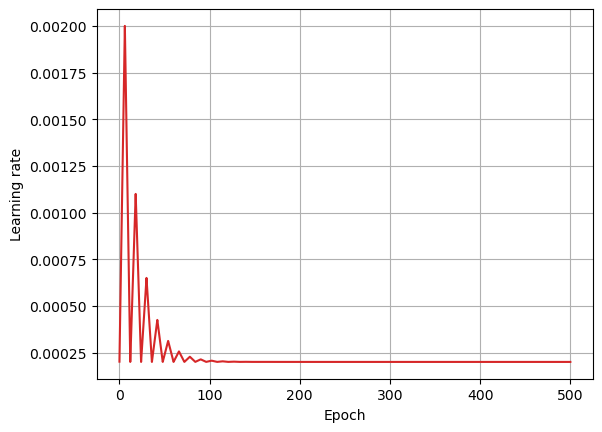

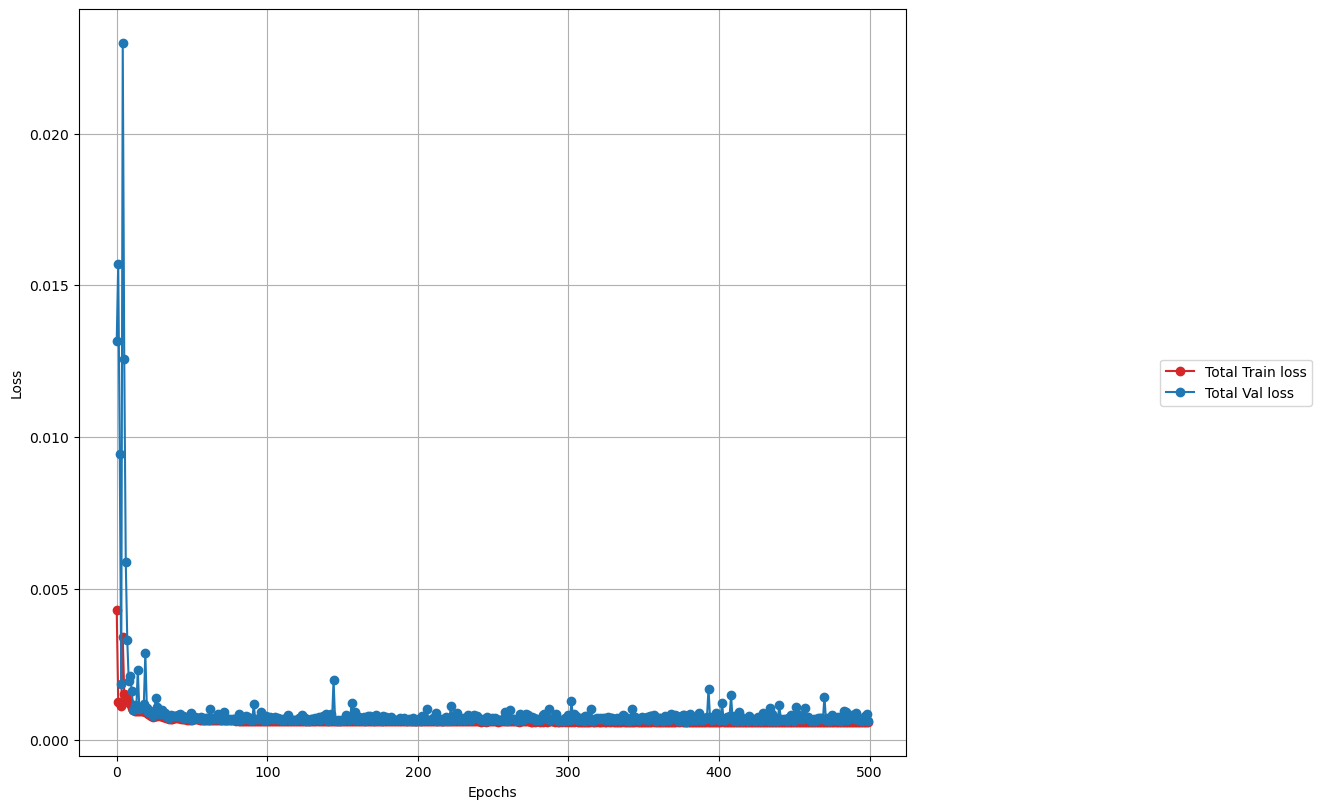

In [12]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.show()

<Figure size 640x480 with 0 Axes>

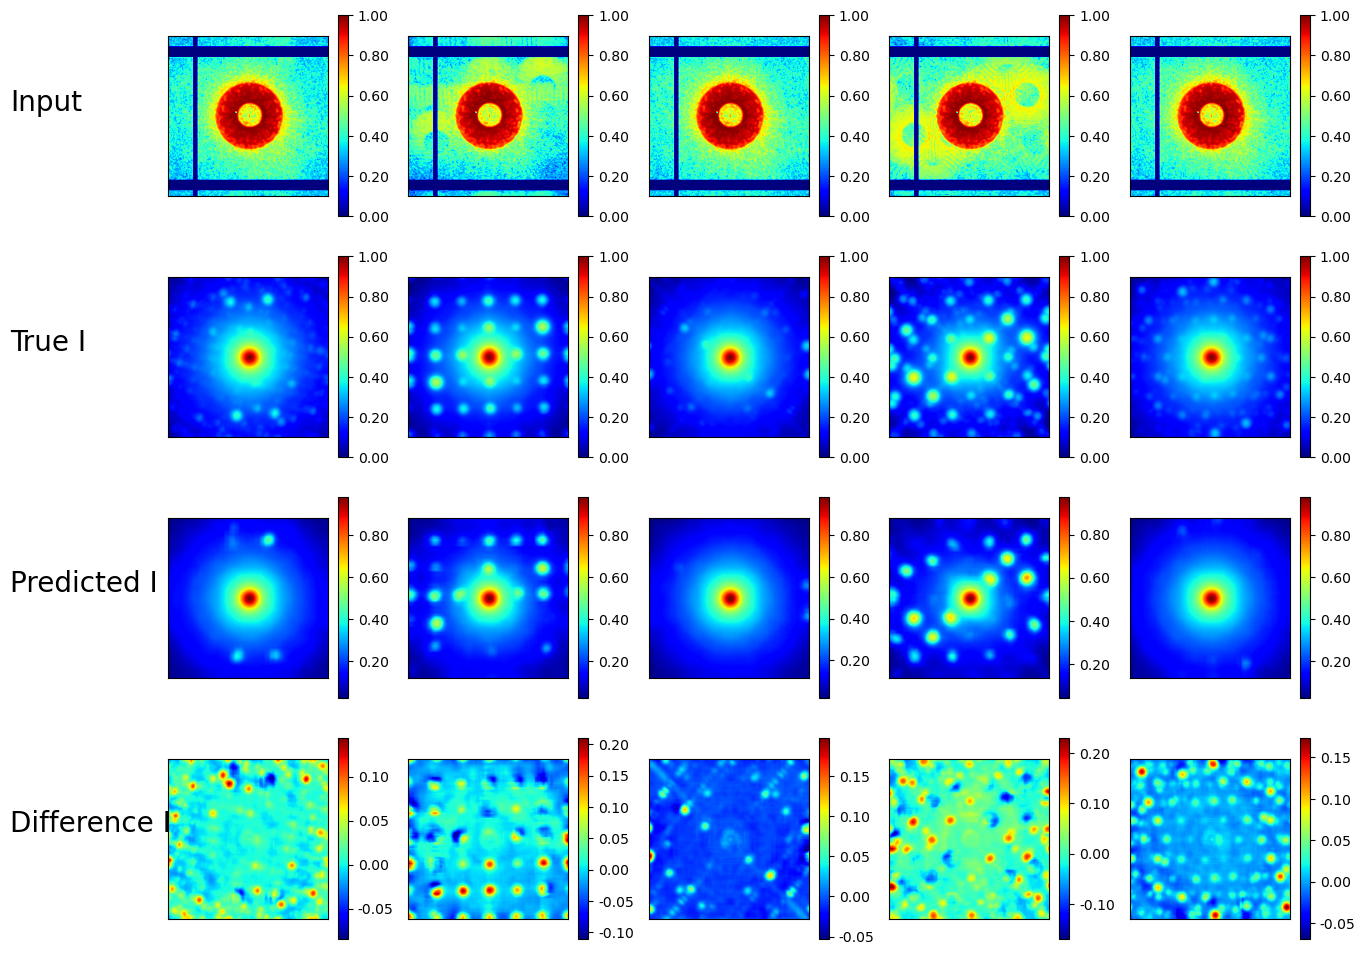

In [13]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

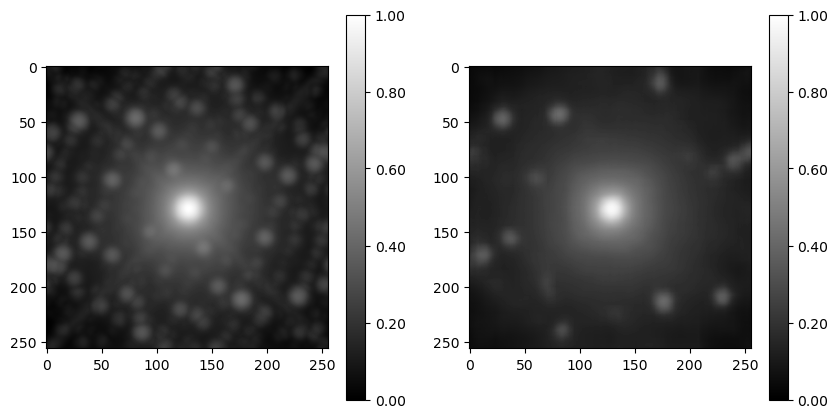

29.263245481200762


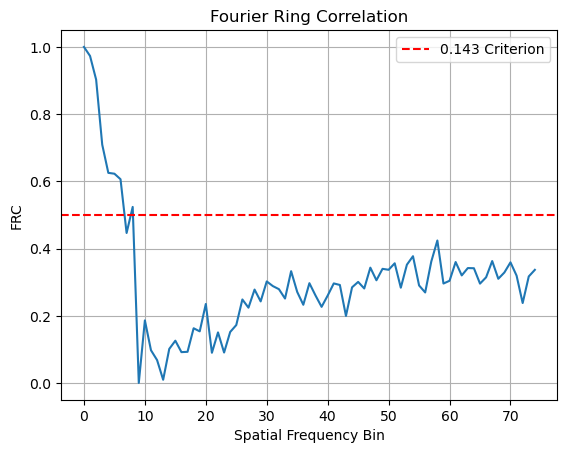

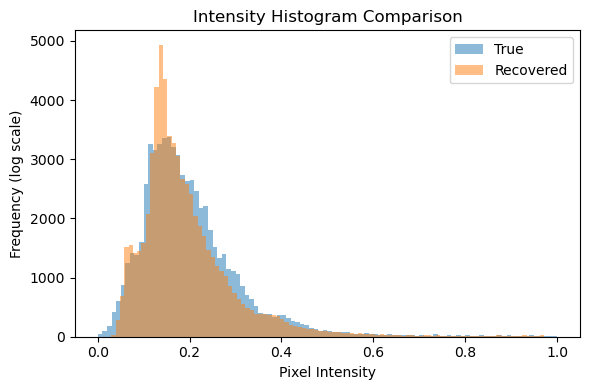

In [16]:
import numpy as np

def compute_psnr(img_true, img_recon, max_val=1.0):
    """Compute PSNR between ground truth and reconstructed images."""
    mse = np.mean((img_true - img_recon) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 10 * np.log10((max_val ** 2) / mse)
    return psnr

from numpy.fft import fft2, fftshift

def compute_frc(image1, image2, num_bins=50):
    """Compute the Fourier Ring Correlation between two images."""
    # Compute Fourier transforms
    F1 = fftshift(fft2(image1))
    F2 = fftshift(fft2(image2))

    fig,ax=plt.subplots(1,2,figsize=(10, 5))
    im1=ax[0].imshow(image1, cmap='gray',clim=(0,1))
    im2=ax[1].imshow(image2, cmap='gray',clim=(0,1))
    plt.colorbar(im1, ax=ax[0], format='%.2f')
    plt.colorbar(im2, ax=ax[1], format='%.2f')
    plt.show()
    # Prepare coordinates
    h, w = F1.shape
    y, x = np.indices((h, w))
    center = (h // 2, w // 2)
    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

    # Bin radial frequencies
    r = r.astype(np.int32)
    max_r = min(center)
    frc = np.zeros(num_bins)
    for i in range(num_bins):
        ring_mask = (r >= i * max_r / num_bins) & (r < (i + 1) * max_r / num_bins)
        F1_ring = F1[ring_mask]
        F2_ring = F2[ring_mask]
        num = np.sum(F1_ring * np.conj(F2_ring))
        denom = np.sqrt(np.sum(np.abs(F1_ring) ** 2) * np.sum(np.abs(F2_ring) ** 2))
        frc[i] = np.abs(num / denom) if denom != 0 else 0
    return frc


import matplotlib.pyplot as plt


def plot_intensity_histograms(img1, img2, labels=('True', 'Recovered'), bins=100):
    plt.figure(figsize=(6,4))
    plt.hist(img1.ravel(), bins=bins, alpha=0.5, label=labels[0])
    plt.hist(img2.ravel(), bins=bins, alpha=0.5, label=labels[1])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency (log scale)')
    plt.title('Intensity Histogram Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
j=int(round(np.random.rand()*ntest))
IMAGE1=Y_I_test[j].reshape(h, w)   
IMAGE2=results[j].reshape(h, w)
frc_curve = compute_frc(IMAGE1, IMAGE2,num_bins=75)
print(compute_psnr(IMAGE1, IMAGE2))
plt.plot(frc_curve)
plt.axhline(0.5, color='r', linestyle='--', label='0.143 Criterion')
plt.xlabel('Spatial Frequency Bin')
plt.ylabel('FRC')
plt.title('Fourier Ring Correlation')
plt.legend()
plt.grid(True)
plt.show()
plot_intensity_histograms(IMAGE1, IMAGE2)

In [52]:
# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/')))

try:
    import encoder1
    importlib.reload(encoder1)
    # Now import the class from the freshly reloaded module
    from encoder1 import recon_model as recon_model2
    print("Successfully imported recon_model")
except Exception as e:
    print(f"Import error: {e}")


base_path=Path("/net/micdata/data2/12IDC/ptychosaxs/")


files=[2,10,25,50,100,150,200,250,300,400,500]
#1,2,3,7,10

model_list=[f"best_model_ZCB_9_Unet_epoch_{f}_pearson_loss.pth" for f in files]
#model_list=[f"best_model_ZCB_9_32_Unet_epoch_{f}_L2.pth" for f in files]

models=[]
for m in model_list:
    #Load lowest validation loss model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_new=recon_model2()
    #model_new=recon_model()
    model_new.load_state_dict(torch.load("/net/micdata/data2/12IDC/ptychosaxs/trained_model/"+m))
    #model_new.load_state_dict(torch.load("/net/micdata/data2/12IDC/ptychosaxs/models/ZCB_9_3D/"+model))
    model_new.to(device)

    #put into eval mode
    model_new.eval()
    models.append(model_new)

Successfully imported recon_model


In [53]:
model=models[-1]
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()


AttributeError: 'str' object has no attribute 'eval'